# <center> École des Ponts ParisTech</center>
## <center> SPH pour l'hydraulique </center>
### <center> Projet SPH GMM 2021</center>
#### <center> Parois mobiles  </center>
<center> Auteurs : Ruben Persicot & Yohan Lanier </center>


<center> Encadrants : Rémi Carmigniani et Damien Violeau </center>


<img src='./Figures/logo_p.jpg' width=200>

## 3. Etude d'un écoulement suite à la chute d'un solide.

### 3.1 Explication de la situation étudiée.

Si dans les deux premières parties du projet on imposait le mouvement des parois, l'objectif de cette dernière partie est de programmer les fonctions adéquates afin de modéliser le mouvement d'un solide. 

On choisit de simuler un écoulement induit par la chute d'un solide dans un bassin.

Précisons que l'on ne résout les équations de la dynamique que pour le déplacement selon la verticale. En effet, nous n'avons pas résolu les équations du moment. 

### 3.2 Etude numérique

#### Import des fichiers et des modules utiles pour programmer un code SPH.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sys import exit
import os.path
from os import path
import csv
import time
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.usetex'] = True
from src.spyh import *
from src.checkTD3 import *
from src.sphvar import *
from src.plotParticles import *
from src.state import *
from src.contrib import *
from src.analytical_solutions import *
from src.solidStuffManagement import *

#### Définition des grandeurs du problèmes et du fluide

In [2]:
#FLUID PARAMETERS 
e = 0.5 #half width in meters
U = 1 # Upper bound velocity
#FLUID PARAMETERS
Re = 1 # Reynolds number
rhoF = 1000
mu = 200 #(Pa.s)
print(mu)
grav = np.array([0.0,-9.81])#np.array([0.0,-9.81])#np.array([0.0,0.0]) #m.s-2#OTHER FLUID PARAMETERS
c0 = 10*U
gamma = 7
B = rhoF*c0**2/gamma 
#DENSITY & SHEPARD THRESHOLDS : 
shepardMin = 10**(-6)
rhoMin = 0.5*rhoF
rhoMax = 1.5*rhoF


200


#### Définition des propriétés des particules

In [3]:
#GEOMETRY
Lx = 2    #Cavity length (m)
Ly = 2    #Cavity height (m)
lx = 0.5  #Solid length  (m)
ly=1      #Solid height  (m)
#PARTICLES & SPACES PARAMETERS : 
dr = ly/50
h = smthfc*dr
m=dr*dr*rhoF
lspace = 2*h
#SOLID PARAMETERS
ls = 0.4        
ws = 0.2
rhoS = 100
ms = dr*dr*rhoS 

#### Création du domaine de calcul

In [4]:
#COMPUTATION DOMAIN : 
xOrigin = -nBound*dr
yOrigin = -nBound*dr
xSize = Lx+2*nBound*dr
ySize = Ly+2*nBound*dr
xMax = xOrigin+xSize
yMax = yOrigin+ySize
#INIT SPACES & PART:
posSpace,neibSpace,partSpace,listNeibSpace = \
init_spaces(xOrigin,yOrigin,xSize,ySize,lspace,dr)
part = init_particles()
#INIT PART 
part = addBox(part,[Lx,Ly/2],FLUID,dr,rhoF)   #Fluid domain
part = addBox(part,[-nBound*dr,-nBound*dr,Lx+2*nBound*dr,nBound*dr],BOUND,dr,rhoF) #Lower boundary domain
part = addBox(part,[-nBound*dr,0,nBound*dr,Ly],BOUND,dr,rhoF) #Left boundary domain
part = addBox(part,[Lx,0,nBound*dr,Ly],BOUND,dr,rhoF) #Right boundary domain
numberOfNonSolidParticles = len(part)
part = addBox(part,[(Lx-ws)/2, (Ly-ls), ws, ls], MOBILESOLID, dr, rhoS)  #Mobile solid domain
part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
numberOfSolidPart = len(part)-numberOfNonSolidParticles

#### Affichage du domaine 

<IPython.core.display.Javascript object>


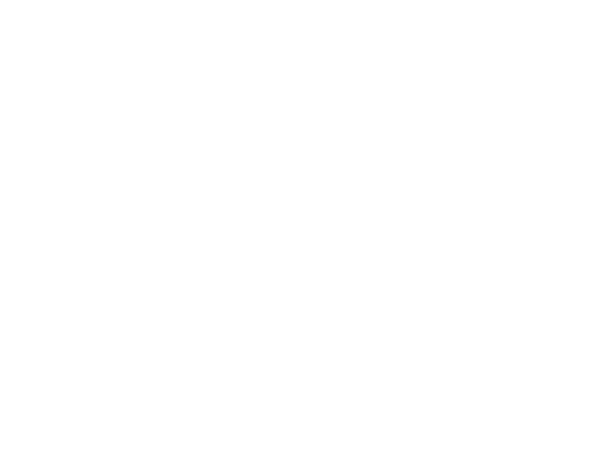

In [5]:
%matplotlib notebook
Umax= 1
tabUx = part[:,VEL[0]]
domain = [xOrigin,xMax,yOrigin,yMax,0,Umax]
plotPropertiesWithBound(part,tabUx,r'$U_x$',domain,dr,1)

#### Affichage des espaces

In [6]:
plotSpaces(posSpace,'k',lspace,1)
neibSpace[2][neibSpace[2]>-1]
spacesOutline(posSpace[neibSpace[2][neibSpace[2]>-1]],'r',lspace,1)

#### Initialisation de la pression

In [7]:
def initWaterPressure(part):
    infoTab = part[:,INFO]
    y_i = part[infoTab == FLUID] [:,POS[1]]
    p_i = np.linalg.norm(grav)*rhoF*(Ly/2-y_i)
    rho_i = density(p_i,B,rhoF,gamma)
    part[infoTab == FLUID, RHO] = rho_i
    return part

#### Affichage du domaine après initialisation de la pression

<IPython.core.display.Javascript object>


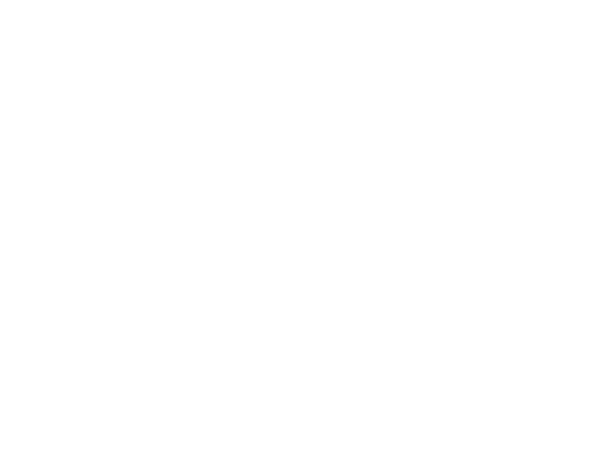

In [8]:
part = initWaterPressure(part)
%matplotlib notebook
Pmax= rhoF*np.linalg.norm(grav)*Ly/2
tabPres = pressure(part[:,RHO],B,rhoF,gamma)
domain = [xOrigin,xMax,yOrigin,yMax,0,Pmax]
plotPropertiesWithBound(part,tabPres,r'Pressure',domain,dr,1)

#### Détermination du centre de gravité, initialisation de la vitesse et de l'accéleration 

In [9]:
infoTab = part[:,INFO]
OG = np.array([1/numberOfSolidPart*np.sum(part[infoTab == MOBILESOLID] [:,POS[0]]),1/numberOfSolidPart*np.sum(part[infoTab == MOBILESOLID] [:,POS[1]])])
V_OG = np.array([0,-10])
A_OG = np.array([0,0])

#### Gestion des enregistrements

In [10]:
current_directory = os.getcwd()
case_directory = os.path.join(current_directory, r'Results/Floating_solid_'+time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(case_directory)
data_directory = os.path.join(case_directory,r'Data')
figures_directory = os.path.join(case_directory,r'Figures')
os.mkdir(data_directory)
os.mkdir(figures_directory)

#### Gestion du pas de temps et des fréquences de sorties des figures

In [11]:
# Here we specify the output frequencies
dt_figure = 0.005#0.025*e**2*rhoF/mu
t_print = 0
#final time :
t_end = 3
t=0
it=0
im_count=0

### 3.3 Simulation SPH

dOG, V_OG :
[ 0.         -0.00400157] [  0.       -10.003924]


<IPython.core.display.Javascript object>


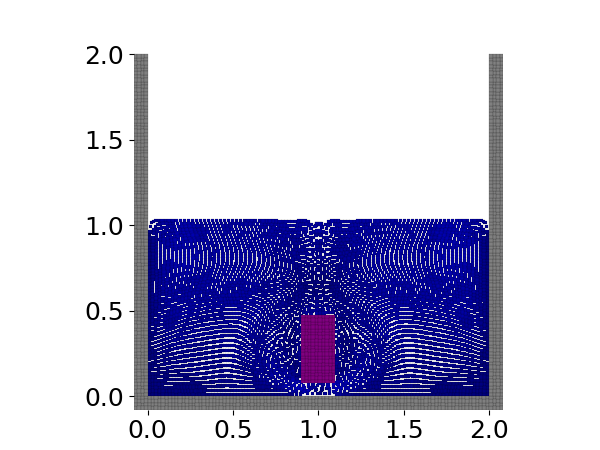

dOG, V_OG :
[ 0.         -0.00100039] [  0.        -10.0049049]
dOG, V_OG :
[ 0.         -0.00100027] [  0.         -10.00588559]
dOG, V_OG :
[ 0.         -0.00100029] [  0.         -10.00686621]
dOG, V_OG :
[ 0.         -0.00100032] [  0.         -10.00784675]
dOG, V_OG :
[ 0.         -0.00100034] [  0.         -10.00882722]
dOG, V_OG :
[ 0.         -0.00100037] [  0.         -10.00980762]
dOG, V_OG :
[ 0.         -0.00100039] [  0.         -10.01078795]
dOG, V_OG :
[ 0.         -0.00100042] [  0.        -10.0117682]
dOG, V_OG :
[ 0.         -0.00100044] [  0.         -10.01274838]
dOG, V_OG :
[ 0.         -0.00100047] [  0.        -10.0137285]
dOG, V_OG :
[ 0.         -0.00100049] [  0.         -10.01470853]
dOG, V_OG :
[ 0.         -0.00100051] [  0.        -10.0156885]
dOG, V_OG :
[ 0.         -0.00100054] [  0.        -10.0166684]
dOG, V_OG :
[ 0.         -0.00100056] [  0.         -10.01764822]
dOG, V_OG :
[ 0.         -0.00100059] [  0.         -10.01862797]
dOG, V_OG :
[ 0.    

dOG, V_OG :
[ 0.         -0.00100331] [  0.         -10.12888051]
dOG, V_OG :
[ 0.         -0.00100334] [  0.         -10.12985217]
dOG, V_OG :
[ 0.         -0.00100336] [  0.         -10.13082375]
dOG, V_OG :
[ 0.         -0.00100338] [  0.         -10.13179527]
dOG, V_OG :
[ 0.         -0.00100341] [  0.         -10.13276671]
dOG, V_OG :
[ 0.         -0.00100343] [  0.         -10.13373809]
dOG, V_OG :
[ 0.         -0.00100345] [  0.         -10.13470939]
dOG, V_OG :
[ 0.         -0.00100348] [  0.         -10.13568063]
dOG, V_OG :
[ 0.        -0.0010035] [  0.         -10.13665179]
dOG, V_OG :
[ 0.         -0.00100353] [  0.         -10.13762289]
dOG, V_OG :
[ 0.         -0.00100355] [  0.         -10.13859391]
dOG, V_OG :
[ 0.         -0.00100357] [  0.         -10.13956487]
dOG, V_OG :
[ 0.        -0.0010036] [  0.         -10.14053575]
dOG, V_OG :
[ 0.         -0.00100362] [  0.         -10.14150657]
dOG, V_OG :
[ 0.         -0.00100364] [  0.         -10.14247731]
dOG, V_OG :
[ 

dOG, V_OG :
[ 0.         -0.00100627] [  0.         -10.25076166]
dOG, V_OG :
[ 0.        -0.0010063] [  0.        -10.2517246]
dOG, V_OG :
[ 0.         -0.00100632] [  0.         -10.25268746]
dOG, V_OG :
[ 0.         -0.00100634] [  0.         -10.25365026]
dOG, V_OG :
[ 0.         -0.00100636] [  0.       -10.254613]
dOG, V_OG :
[ 0.         -0.00100639] [  0.         -10.25557566]
dOG, V_OG :
[ 0.         -0.00100641] [  0.         -10.25653825]
dOG, V_OG :
[ 0.         -0.00100643] [  0.         -10.25750078]
dOG, V_OG :
[ 0.         -0.00100646] [  0.         -10.25846324]
dOG, V_OG :
[ 0.         -0.00100648] [  0.         -10.25942563]
dOG, V_OG :
[ 0.        -0.0010065] [  0.         -10.26038795]
dOG, V_OG :
[ 0.         -0.00100653] [  0.         -10.26135021]
dOG, V_OG :
[ 0.         -0.00100655] [  0.         -10.26231239]
dOG, V_OG :
[ 0.         -0.00100657] [  0.         -10.26327451]
dOG, V_OG :
[ 0.        -0.0010066] [  0.         -10.26423656]
dOG, V_OG :
[ 0.      

dOG, V_OG :
[ 0.         -0.00100915] [  0.         -10.37155875]
dOG, V_OG :
[ 0.         -0.00100918] [  0.        -10.3725132]
dOG, V_OG :
[ 0.        -0.0010092] [  0.         -10.37346758]
dOG, V_OG :
[ 0.         -0.00100922] [  0.         -10.37442189]
dOG, V_OG :
[ 0.         -0.00100924] [  0.         -10.37537614]
dOG, V_OG :
[ 0.         -0.00100927] [  0.         -10.37633033]
dOG, V_OG :
[ 0.         -0.00100929] [  0.         -10.37728444]
dOG, V_OG :
[ 0.         -0.00100931] [  0.         -10.37823849]
dOG, V_OG :
[ 0.         -0.00100933] [  0.         -10.37919247]
dOG, V_OG :
[ 0.         -0.00100936] [  0.         -10.38014639]
dOG, V_OG :
[ 0.         -0.00100938] [  0.         -10.38110024]
dOG, V_OG :
[ 0.        -0.0010094] [  0.         -10.38205402]
dOG, V_OG :
[ 0.         -0.00100942] [  0.         -10.38300774]
dOG, V_OG :
[ 0.         -0.00100945] [  0.         -10.38396139]
dOG, V_OG :
[ 0.         -0.00100947] [  0.         -10.38491498]
dOG, V_OG :
[ 0.

dOG, V_OG :
[ 0.         -0.00101194] [  0.         -10.49035396]
dOG, V_OG :
[ 0.         -0.00101196] [  0.         -10.49130021]
dOG, V_OG :
[ 0.         -0.00101198] [  0.         -10.49224639]
dOG, V_OG :
[ 0.         -0.00101201] [  0.        -10.4931925]
dOG, V_OG :
[ 0.         -0.00101203] [  0.         -10.49413855]
dOG, V_OG :
[ 0.         -0.00101205] [  0.         -10.49508454]
dOG, V_OG :
[ 0.         -0.00101207] [  0.         -10.49603046]
dOG, V_OG :
[ 0.         -0.00101209] [  0.         -10.49697632]
dOG, V_OG :
[ 0.         -0.00101212] [  0.         -10.49792211]
dOG, V_OG :
[ 0.         -0.00101214] [  0.         -10.49886784]
dOG, V_OG :
[ 0.         -0.00101216] [  0.        -10.4998135]
dOG, V_OG :
[ 0.         -0.00101218] [  0.        -10.5007591]
dOG, V_OG :
[ 0.        -0.0010122] [  0.         -10.50170463]
dOG, V_OG :
[ 0.         -0.00101223] [  0.        -10.5026501]
dOG, V_OG :
[ 0.         -0.00101225] [  0.        -10.5035955]
dOG, V_OG :
[ 0.      

dOG, V_OG :
[ 1.25808004e-19 -9.87718179e-04] [ 1.23606735e-15 -9.70436023e+00]
dOG, V_OG :
[ 1.23485364e-19 -9.86778059e-04] [ 1.20977625e-15 -9.66738589e+00]
dOG, V_OG :
[ 1.21948684e-19 -9.85847715e-04] [ 1.19131994e-15 -9.63077254e+00]
dOG, V_OG :
[ 1.19224746e-19 -9.84923906e-04] [ 1.16141429e-15 -9.59452403e+00]
dOG, V_OG :
[ 1.15325056e-19 -9.84001917e-04] [ 1.12026959e-15 -9.55861162e+00]
dOG, V_OG :
[ 1.09287110e-19 -9.83077161e-04] [ 1.05865494e-15 -9.52298481e+00]
dOG, V_OG :
[ 1.00073115e-19 -9.82146855e-04] [ 9.66711496e-16 -9.48758970e+00]
dOG, V_OG :
[ 8.79847914e-20 -9.81210661e-04] [ 8.47591795e-16 -9.45238481e+00]
dOG, V_OG :
[ 7.40231477e-20 -9.80270056e-04] [ 7.11132316e-16 -9.41734763e+00]
dOG, V_OG :
[ 5.85120883e-20 -9.79327187e-04] [ 5.60576777e-16 -9.38247282e+00]
dOG, V_OG :
[ 4.21710563e-20 -9.78383981e-04] [ 4.02914587e-16 -9.34776626e+00]
dOG, V_OG :
[ 2.47942913e-20 -9.77441796e-04] [ 2.36244420e-16 -9.31323939e+00]
dOG, V_OG :
[ 6.52635494e-21 -9.76501471

ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
dOG, V_OG :
[ 8.97171715e-08 -9.33148525e-04] [ 7.55585280e-04 -7.85884439e+00]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
dOG, V_OG :
[ 8.95894812e-08 -9.32435835e-04] [ 7.53012772e-04 -7.83726040e+00]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
dOG, V_OG :
[ 8.92750492e-08 -9.31743762e-04] [ 7.48904937e-04 -7.81615367e+00]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
dOG, V_OG :
[ 8.87904992e-08 -9.31031881e-04] [ 7.43413429e-04 -7.79522144e+00]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
dOG, V_OG :
[ 8.81404430e-08 -9.30324856e-04] [ 7.36579301e-04 -7.77461525e+00]
ATTENTION : too many neibs in a space... increase maxPartInSpace in sphvar.py
dOG, V_OG :
[ 8.80290140e-08 -9.29659991e-04] [ 7.34273295e-04 -7.75453994e+00]
ATTENTION : too many neibs in a space... increase ma

dOG, V_OG :
[ 1.43218788e-07 -8.84445697e-04] [ 1.06944855e-03 -6.60436512e+00]
dOG, V_OG :
[ 1.46278406e-07 -8.83961475e-04] [ 1.09106740e-03 -6.59332828e+00]
dOG, V_OG :
[ 1.49429267e-07 -8.83482470e-04] [ 1.11332495e-03 -6.58239912e+00]
dOG, V_OG :
[ 1.52672924e-07 -8.83009277e-04] [ 1.13623220e-03 -6.57158814e+00]
dOG, V_OG :
[ 1.56011012e-07 -8.82542490e-04] [ 1.15980094e-03 -6.56090618e+00]
dOG, V_OG :
[ 1.59444423e-07 -8.82082661e-04] [ 1.18403759e-03 -6.55036409e+00]
dOG, V_OG :
[ 1.62972573e-07 -8.81630253e-04] [ 1.20893775e-03 -6.53997218e+00]
dOG, V_OG :
[ 1.66590985e-07 -8.81185582e-04] [ 1.23446838e-03 -6.52973952e+00]
dOG, V_OG :
[ 1.70286201e-07 -8.80748742e-04] [ 1.26053016e-03 -6.51967303e+00]
dOG, V_OG :
[ 1.74026588e-07 -8.80319514e-04] [ 1.28688974e-03 -6.50977627e+00]
dOG, V_OG :
[ 1.77747992e-07 -8.79897261e-04] [ 1.31307431e-03 -6.50004803e+00]
dOG, V_OG :
[ 1.81335555e-07 -8.79480811e-04] [ 1.33823831e-03 -6.49048065e+00]
dOG, V_OG :
[ 1.84605489e-07 -8.79068342

dOG, V_OG :
[ 2.60307937e-07 -8.37222557e-04] [ 1.75624662e-03 -5.64857647e+00]
dOG, V_OG :
[ 2.60734402e-07 -8.36767688e-04] [ 1.75750069e-03 -5.64029822e+00]
dOG, V_OG :
[ 2.61145286e-07 -8.36312723e-04] [ 1.75864715e-03 -5.63203345e+00]
dOG, V_OG :
[ 2.61540283e-07 -8.35857665e-04] [ 1.75968426e-03 -5.62378217e+00]
dOG, V_OG :
[ 2.61919205e-07 -8.35402518e-04] [ 1.76061107e-03 -5.61554438e+00]
dOG, V_OG :
[ 2.62281954e-07 -8.34947290e-04] [ 1.76142721e-03 -5.60732013e+00]
dOG, V_OG :
[ 2.62628595e-07 -8.34491987e-04] [ 1.76213346e-03 -5.59910947e+00]
dOG, V_OG :
[ 2.62959288e-07 -8.34036619e-04] [ 1.76273119e-03 -5.59091246e+00]
dOG, V_OG :
[ 2.63274285e-07 -8.33581195e-04] [ 1.76322241e-03 -5.58272921e+00]
dOG, V_OG :
[ 2.63573943e-07 -8.33125726e-04] [ 1.76360982e-03 -5.57455982e+00]
dOG, V_OG :
[ 2.63858679e-07 -8.32670225e-04] [ 1.76389653e-03 -5.56640443e+00]
dOG, V_OG :
[ 2.64128928e-07 -8.32214708e-04] [ 1.76408574e-03 -5.55826319e+00]
dOG, V_OG :
[ 2.64385121e-07 -8.31759190

dOG, V_OG :
[ 2.89801355e-07 -7.94020178e-04] [ 1.79558862e-03 -4.91969263e+00]
dOG, V_OG :
[ 2.91372127e-07 -7.93706385e-04] [ 1.80424225e-03 -4.91480983e+00]
dOG, V_OG :
[ 2.92917153e-07 -7.93393613e-04] [ 1.81273216e-03 -4.90995526e+00]
dOG, V_OG :
[ 2.9442850e-07 -7.9308167e-04] [ 1.82100906e-03 -4.90512605e+00]
dOG, V_OG :
[ 2.95898523e-07 -7.92770368e-04] [ 1.82902552e-03 -4.90031928e+00]
dOG, V_OG :
[ 2.97320007e-07 -7.92459520e-04] [ 1.83673689e-03 -4.89553209e+00]
dOG, V_OG :
[ 2.98686335e-07 -7.92148946e-04] [ 1.84410225e-03 -4.89076159e+00]
dOG, V_OG :
[ 2.99991490e-07 -7.91838469e-04] [ 1.85108450e-03 -4.88600499e+00]
dOG, V_OG :
[ 3.01230063e-07 -7.91527922e-04] [ 1.85765034e-03 -4.88125953e+00]
dOG, V_OG :
[ 3.02397237e-07 -7.91217143e-04] [ 1.86377022e-03 -4.87652257e+00]
dOG, V_OG :
[ 3.03488967e-07 -7.90905981e-04] [ 1.86941940e-03 -4.87179156e+00]
dOG, V_OG :
[ 3.04501772e-07 -7.90594291e-04] [ 1.87457669e-03 -4.86706404e+00]
dOG, V_OG :
[ 3.05432847e-07 -7.90281940e-

dOG, V_OG :
[ 3.28927553e-07 -7.60462125e-04] [ 1.91805170e-03 -4.43442838e+00]
dOG, V_OG :
[ 3.31082742e-07 -7.60139657e-04] [ 1.92954589e-03 -4.43008397e+00]
dOG, V_OG :
[ 3.33000436e-07 -7.59815640e-04] [ 1.93963946e-03 -4.42572513e+00]
dOG, V_OG :
[ 3.34691515e-07 -7.59490078e-04] [ 1.94839781e-03 -4.42135143e+00]
dOG, V_OG :
[ 3.36167953e-07 -7.59162988e-04] [ 1.95589263e-03 -4.41696266e+00]
dOG, V_OG :
[ 3.37442370e-07 -7.58834391e-04] [ 1.96219927e-03 -4.41255877e+00]
dOG, V_OG :
[ 3.38527671e-07 -7.58504317e-04] [ 1.96739464e-03 -4.40813988e+00]
dOG, V_OG :
[ 3.39436736e-07 -7.58172800e-04] [ 1.97155538e-03 -4.40370621e+00]
dOG, V_OG :
[ 3.40182148e-07 -7.57839880e-04] [ 1.97475629e-03 -4.39925809e+00]
dOG, V_OG :
[ 3.40775436e-07 -7.57505599e-04] [ 1.97706593e-03 -4.39479596e+00]
dOG, V_OG :
[ 3.41228663e-07 -7.57170001e-04] [ 1.97855584e-03 -4.39032030e+00]
dOG, V_OG :
[ 3.41553644e-07 -7.56833134e-04] [ 1.97929598e-03 -4.38583166e+00]
dOG, V_OG :
[ 3.41760951e-07 -7.56495043

dOG, V_OG :
[ 1.38336861e-07 -7.19210975e-04] [ 7.53489110e-04 -3.91737699e+00]
dOG, V_OG :
[ 1.32601870e-07 -7.18579095e-04] [ 7.21560397e-04 -3.91018783e+00]
dOG, V_OG :
[ 1.26777996e-07 -7.17931884e-04] [ 6.89195043e-04 -3.90284680e+00]
dOG, V_OG :
[ 1.20864857e-07 -7.17268551e-04] [ 6.56393551e-04 -3.89534611e+00]
dOG, V_OG :
[ 1.14861954e-07 -7.16588276e-04] [ 6.23155964e-04 -3.88767769e+00]
dOG, V_OG :
[ 1.08767396e-07 -7.15890214e-04] [ 5.89474965e-04 -3.87983325e+00]
dOG, V_OG :
[ 1.02578151e-07 -7.15173496e-04] [ 5.55337308e-04 -3.87180426e+00]
dOG, V_OG :
[ 9.62936123e-08 -7.14437224e-04] [ 5.20743118e-04 -3.86358200e+00]
dOG, V_OG :
[ 8.99154477e-08 -7.13680481e-04] [ 4.85705055e-04 -3.85515755e+00]
dOG, V_OG :
[ 8.34441148e-08 -7.12902326e-04] [ 4.50229431e-04 -3.84652183e+00]
dOG, V_OG :
[ 7.68782987e-08 -7.12101801e-04] [ 4.14313239e-04 -3.83766562e+00]
dOG, V_OG :
[ 7.02165926e-08 -7.11277935e-04] [ 3.77953262e-04 -3.82857962e+00]
dOG, V_OG :
[ 6.34575344e-08 -7.10429743

dOG, V_OG :
[-5.77344292e-07 -5.74964263e-04] [-0.00254841 -2.53790542]
dOG, V_OG :
[-5.59701515e-07 -5.73899163e-04] [-2.46696821e-03 -2.52954647e+00]
dOG, V_OG :
[-5.41195242e-07 -5.72839184e-04] [-2.38198441e-03 -2.52126017e+00]
dOG, V_OG :
[-5.22303371e-07 -5.71783291e-04] [-2.29556989e-03 -2.51303854e+00]
dOG, V_OG :
[-5.03524797e-07 -5.70730459e-04] [-2.20991522e-03 -2.50487351e+00]
dOG, V_OG :
[-4.85359403e-07 -5.69679684e-04] [-2.12720330e-03 -2.49675704e+00]
dOG, V_OG :
[-4.68286598e-07 -5.68630029e-04] [-2.04951564e-03 -2.48868138e+00]
dOG, V_OG :
[-4.52735225e-07 -5.67580626e-04] [-1.97870172e-03 -2.48063924e+00]
dOG, V_OG :
[-4.39071620e-07 -5.66530704e-04] [-1.91632858e-03 -2.47262389e+00]
dOG, V_OG :
[-4.27592453e-07 -5.65479609e-04] [-1.86365152e-03 -2.46462940e+00]
dOG, V_OG :
[-4.18518875e-07 -5.64426802e-04] [-1.82159078e-03 -2.45665064e+00]
dOG, V_OG :
[-4.12008383e-07 -5.63371860e-04] [-1.79078532e-03 -2.44868333e+00]
dOG, V_OG :
[-4.08147006e-07 -5.62314465e-04] [-

dOG, V_OG :
[-1.84047128e-07 -4.61422804e-04] [-7.05597459e-04 -1.76899667e+00]
dOG, V_OG :
[-1.90820738e-07 -4.60470744e-04] [-7.30759163e-04 -1.76339961e+00]
dOG, V_OG :
[-1.98868940e-07 -4.59520816e-04] [-7.60742971e-04 -1.75782719e+00]
dOG, V_OG :
[-2.08451687e-07 -4.58573060e-04] [-7.96526564e-04 -1.75227953e+00]
dOG, V_OG :
[-2.19908803e-07 -4.57627495e-04] [-8.39388297e-04 -1.74675665e+00]
dOG, V_OG :
[-2.33675015e-07 -4.56684101e-04] [-8.90962891e-04 -1.74125842e+00]
dOG, V_OG :
[-2.50293671e-07 -4.55742786e-04] [-9.53291773e-04 -1.73578440e+00]
dOG, V_OG :
[-2.70424834e-07 -4.54803340e-04] [-1.02885169e-03 -1.73033364e+00]
dOG, V_OG :
[-2.94834829e-07 -4.53865370e-04] [-1.12051264e-03 -1.72490436e+00]
dOG, V_OG :
[-3.24375489e-07 -4.52928225e-04] [-1.23145688e-03 -1.71949361e+00]
dOG, V_OG :
[-3.59907518e-07 -4.51990910e-04] [-1.36488659e-03 -1.71409682e+00]
dOG, V_OG :
[-4.02176827e-07 -4.51052001e-04] [-1.52355496e-03 -1.70870738e+00]
dOG, V_OG :
[-4.51625413e-07 -4.50109603

dOG, V_OG :
[ 1.50847542e-07 -3.00341304e-04] [ 4.88785520e-04 -9.73184435e-01]
dOG, V_OG :
[ 1.30501200e-07 -2.98365683e-04] [ 4.22045092e-04 -9.64924246e-01]
dOG, V_OG :
[ 1.09316596e-07 -2.96389086e-04] [ 3.52854661e-04 -9.56691615e-01]
dOG, V_OG :
[ 8.73004249e-08 -2.94411551e-04] [ 2.81250112e-04 -9.48486583e-01]
dOG, V_OG :
[ 6.45186903e-08 -2.92433094e-04] [ 2.07457751e-04 -9.40309109e-01]
dOG, V_OG :
[ 4.10332888e-08 -2.90453735e-04] [ 1.31688979e-04 -9.32159155e-01]
dOG, V_OG :
[ 1.68437785e-08 -2.88473469e-04] [ 5.39538962e-05 -9.24036589e-01]
dOG, V_OG :
[-7.99252461e-09 -2.86492282e-04] [-2.55528103e-05 -9.15941246e-01]
dOG, V_OG :
[-3.33665083e-08 -2.84510156e-04] [-1.06472648e-04 -9.07872933e-01]
dOG, V_OG :
[-5.92292058e-08 -2.82527065e-04] [-1.88641399e-04 -8.99831428e-01]
dOG, V_OG :
[-8.55317643e-08 -2.80542986e-04] [-2.71896441e-04 -8.91816507e-01]
dOG, V_OG :
[-1.12223288e-07 -2.78557895e-04] [-3.56069887e-04 -8.83827951e-01]
dOG, V_OG :
[-1.39281784e-07 -2.76571768

dOG, V_OG :
[-5.73641852e-07 -1.08413237e-04] [-0.0016442  -0.31073913]
dOG, V_OG :
[-5.65442490e-07 -1.07627572e-04] [-0.00161945 -0.3082498 ]
dOG, V_OG :
[-5.57391150e-07 -1.06855504e-04] [-0.00159522 -0.30581311]
dOG, V_OG :
[-5.49511991e-07 -1.06100271e-04] [-0.00157151 -0.30342845]
dOG, V_OG :
[-5.41818446e-07 -1.05361862e-04] [-0.00154837 -0.30109525]
dOG, V_OG :
[-5.34318071e-07 -1.04640108e-04] [-0.00152581 -0.29881291]
dOG, V_OG :
[-5.27019153e-07 -1.03934848e-04] [-0.00150386 -0.29658088]
dOG, V_OG :
[-5.19938889e-07 -1.03245926e-04] [-0.00148257 -0.29439862]
dOG, V_OG :
[-5.13091326e-07 -1.02573192e-04] [-0.00146197 -0.29226559]
dOG, V_OG :
[-5.06484942e-07 -1.01916499e-04] [-0.00144209 -0.29018129]
dOG, V_OG :
[-5.00121825e-07 -1.01275705e-04] [-0.00142292 -0.28814519]
dOG, V_OG :
[-4.94000581e-07 -1.00650674e-04] [-0.00140448 -0.28615681]
dOG, V_OG :
[-4.88114195e-07 -1.00041274e-04] [-0.00138672 -0.28421568]
dOG, V_OG :
[-4.82456444e-07 -9.94473795e-05] [-0.00136965 -0.28

dOG, V_OG :
[-3.13014750e-07 -9.53071748e-05] [-0.00084966 -0.25870695]
dOG, V_OG :
[-3.12483207e-07 -9.56066012e-05] [-0.00084793 -0.25943134]
dOG, V_OG :
[-3.11998580e-07 -9.59106743e-05] [-0.00084632 -0.2601664 ]
dOG, V_OG :
[-3.11564931e-07 -9.62194292e-05] [-0.00084485 -0.26091216]
dOG, V_OG :
[-3.11185547e-07 -9.65329006e-05] [-0.00084352 -0.26166865]
dOG, V_OG :
[-3.10843196e-07 -9.68511286e-05] [-0.00084229 -0.26243593]
dOG, V_OG :
[-3.10515110e-07 -9.71741552e-05] [-0.00084109 -0.26321404]
dOG, V_OG :
[-3.10188048e-07 -9.75020175e-05] [-0.00083989 -0.26400302]
dOG, V_OG :
[-3.09843862e-07 -9.78347529e-05] [-0.00083863 -0.26480293]
dOG, V_OG :
[-3.09455853e-07 -9.81724027e-05] [-0.00083726 -0.2656138 ]
dOG, V_OG :
[-3.09002846e-07 -9.85150120e-05] [-0.0008357 -0.2664357]
dOG, V_OG :
[-3.08445196e-07 -9.88604053e-05] [-0.00083388 -0.26726869]
dOG, V_OG :
[-3.07754869e-07 -9.92104566e-05] [-0.0008317  -0.26811282]
dOG, V_OG :
[-3.06909844e-07 -9.95654500e-05] [-0.00082909 -0.2689

dOG, V_OG :
[ 2.58451356e-08 -1.45891783e-04] [ 7.24776776e-05 -4.09125252e-01]
dOG, V_OG :
[ 2.98236743e-08 -1.46541464e-04] [ 8.36800644e-05 -4.11169966e-01]
dOG, V_OG :
[ 3.37956939e-08 -1.47193682e-04] [ 9.48765143e-05 -4.13224938e-01]
dOG, V_OG :
[ 3.77611945e-08 -1.47848377e-04] [ 1.06067088e-04 -4.15290009e-01]
dOG, V_OG :
[ 4.17201198e-08 -1.48505487e-04] [ 1.17251684e-04 -4.17365016e-01]
dOG, V_OG :
[ 4.5672474e-08 -1.4916495e-04] [ 1.28430370e-04 -4.19449792e-01]
dOG, V_OG :
[ 4.96185763e-08 -1.49826703e-04] [ 1.39604096e-04 -4.21544166e-01]
dOG, V_OG :
[ 5.35588070e-08 -1.50490682e-04] [ 1.50773984e-04 -4.23647967e-01]
dOG, V_OG :
[ 5.74935910e-08 -1.51156823e-04] [ 1.61941283e-04 -4.25761018e-01]
dOG, V_OG :
[ 6.14233383e-08 -1.51825060e-04] [ 1.73107199e-04 -4.27883140e-01]
dOG, V_OG :
[ 6.53485277e-08 -1.52495327e-04] [ 1.84273132e-04 -4.30014150e-01]
dOG, V_OG :
[ 6.92696564e-08 -1.53167558e-04] [ 1.95440535e-04 -4.32153862e-01]
dOG, V_OG :
[ 7.31871000e-08 -1.53841685e-

dOG, V_OG :
[ 3.84723792e-07 -2.18421993e-04] [ 0.00114908 -0.65237414]
dOG, V_OG :
[ 3.86237789e-07 -2.18982212e-04] [ 0.00115418 -0.65437899]
dOG, V_OG :
[ 3.87693398e-07 -2.19539434e-04] [ 0.00115912 -0.65637518]
dOG, V_OG :
[ 3.89089550e-07 -2.20093648e-04] [ 0.00116388 -0.65836262]
dOG, V_OG :
[ 3.90425180e-07 -2.20644839e-04] [ 0.00116846 -0.66034124]
dOG, V_OG :
[ 3.91699217e-07 -2.21192993e-04] [ 0.00117285 -0.66231097]
dOG, V_OG :
[ 3.92910617e-07 -2.21738096e-04] [ 0.00117706 -0.66427171]
dOG, V_OG :
[ 3.94058369e-07 -2.22280135e-04] [ 0.00118108 -0.6662234 ]
dOG, V_OG :
[ 3.95141445e-07 -2.22819095e-04] [ 0.00118491 -0.66816595]
dOG, V_OG :
[ 3.96158806e-07 -2.23354962e-04] [ 0.00118854 -0.67009927]
dOG, V_OG :
[ 3.97109503e-07 -2.23887720e-04] [ 0.00119197 -0.6720233 ]
dOG, V_OG :
[ 3.97992632e-07 -2.24417357e-04] [ 0.00119519 -0.67393795]
dOG, V_OG :
[ 3.98807253e-07 -2.24943857e-04] [ 0.00119822 -0.67584313]
dOG, V_OG :
[ 3.99552362e-07 -2.25467205e-04] [ 0.00120103 -0.67

dOG, V_OG :
[ 6.76321157e-09 -2.58435814e-04] [ 2.09691032e-05 -8.01271287e-01]
dOG, V_OG :
[-2.24376485e-09 -2.58526032e-04] [-6.95738306e-06 -8.01627959e-01]
dOG, V_OG :
[-1.12579230e-08 -2.58609839e-04] [-3.49112992e-05 -8.01960137e-01]
dOG, V_OG :
[-2.02699533e-08 -2.58687177e-04] [-6.28632874e-05 -8.02267580e-01]
dOG, V_OG :
[-2.92728017e-08 -2.58757984e-04] [-9.07909693e-05 -8.02550041e-01]
dOG, V_OG :
[-3.82561187e-08 -2.58822196e-04] [-1.18661731e-04 -8.02807261e-01]
dOG, V_OG :
[-4.72161485e-08 -2.58879751e-04] [-1.46463399e-04 -8.03038992e-01]
dOG, V_OG :
[-5.61564650e-08 -2.58930586e-04] [-1.74206529e-04 -8.03244983e-01]
dOG, V_OG :
[-6.50691858e-08 -2.58974631e-04] [-2.01866136e-04 -8.03424963e-01]
dOG, V_OG :
[-7.39462029e-08 -2.59011809e-04] [-2.29416523e-04 -8.03578632e-01]
dOG, V_OG :
[-8.2786640e-08 -2.5904204e-04] [-2.56854422e-04 -8.03705688e-01]
dOG, V_OG :
[-9.15997936e-08 -2.59065251e-04] [-2.84208124e-04 -8.03805839e-01]
dOG, V_OG :
[-1.00389125e-07 -2.59081369e-

dOG, V_OG :
[ 1.33015360e-07 -2.13553564e-04] [ 3.96681412e-04 -6.36864263e-01]
dOG, V_OG :
[ 1.42743831e-07 -2.12510285e-04] [ 4.25302822e-04 -6.33170788e-01]
dOG, V_OG :
[ 1.52337757e-07 -2.11458734e-04] [ 4.53467599e-04 -6.29454485e-01]
dOG, V_OG :
[ 1.61782479e-07 -2.10399187e-04] [ 4.81132863e-04 -6.25716479e-01]
dOG, V_OG :
[ 1.71061626e-07 -2.09331914e-04] [ 5.08250859e-04 -6.21957875e-01]
dOG, V_OG :
[ 1.80156804e-07 -2.08257180e-04] [ 5.34768063e-04 -6.18179752e-01]
dOG, V_OG :
[ 1.89047258e-07 -2.07175244e-04] [ 5.60624188e-04 -6.14383166e-01]
dOG, V_OG :
[ 1.97709475e-07 -2.06086359e-04] [ 5.85751063e-04 -6.10569141e-01]
dOG, V_OG :
[ 2.06116756e-07 -2.04990771e-04] [ 0.00061007 -0.60673867]
dOG, V_OG :
[ 2.14238738e-07 -2.03888716e-04] [ 0.0006335 -0.6028927]
dOG, V_OG :
[ 2.22040853e-07 -2.02780422e-04] [ 0.00065593 -0.59903217]
dOG, V_OG :
[ 2.29483742e-07 -2.01666107e-04] [ 0.00067725 -0.59515795]
dOG, V_OG :
[ 2.36522615e-07 -2.00545980e-04] [ 0.00069734 -0.59127089]
dO

dOG, V_OG :
[ 4.73071076e-07 -6.80607351e-05] [ 0.00133406 -0.19193138]
dOG, V_OG :
[ 4.79718389e-07 -6.67825523e-05] [ 0.00135255 -0.18829135]
dOG, V_OG :
[ 4.85942306e-07 -6.55065546e-05] [ 0.00136983 -0.18465753]
dOG, V_OG :
[ 4.91746588e-07 -6.42326763e-05] [ 0.00138591 -0.18102979]
dOG, V_OG :
[ 4.97135512e-07 -6.29608519e-05] [ 0.0014008  -0.17740804]
dOG, V_OG :
[ 5.02113818e-07 -6.16910161e-05] [ 0.00141452 -0.17379216]
dOG, V_OG :
[ 5.06686679e-07 -6.04231037e-05] [ 0.00142709 -0.17018206]
dOG, V_OG :
[ 5.1085966e-07 -5.9157049e-05] [ 0.00143851 -0.16657762]
dOG, V_OG :
[ 5.14638693e-07 -5.78927862e-05] [ 0.0014488  -0.16297873]
dOG, V_OG :
[ 5.18030020e-07 -5.66302484e-05] [ 0.00145799 -0.15938529]
dOG, V_OG :
[ 5.21038633e-07 -5.53692119e-05] [ 0.00146609 -0.15579721]
dOG, V_OG :
[ 5.23670147e-07 -5.41095115e-05] [ 0.00147313 -0.15221438]
dOG, V_OG :
[ 5.25934311e-07 -5.28513752e-05] [ 0.00147911 -0.1486367 ]
dOG, V_OG :
[ 5.27838361e-07 -5.15947315e-05] [ 0.00148407 -0.1450

dOG, V_OG :
[2.06843458e-07 7.03235308e-05] [0.00060041 0.20413035]
dOG, V_OG :
[2.00184337e-07 7.11430526e-05] [0.00058122 0.20655714]
dOG, V_OG :
[1.93374812e-07 7.19412934e-05] [0.00056157 0.20892195]
dOG, V_OG :
[1.86419263e-07 7.27171788e-05] [0.00054149 0.2112215 ]
dOG, V_OG :
[1.79322142e-07 7.34700238e-05] [0.00052098 0.21345248]
dOG, V_OG :
[1.72086076e-07 7.41987305e-05] [0.00050006 0.21561155]
dOG, V_OG :
[1.64712929e-07 7.49021899e-05] [0.00047872 0.21769538]
dOG, V_OG :
[1.57203737e-07 7.55793035e-05] [0.00045697 0.21970068]
dOG, V_OG :
[1.49558588e-07 7.62289941e-05] [0.00043482 0.22162428]
dOG, V_OG :
[1.41776815e-07 7.68502090e-05] [0.00041226 0.22346309]
dOG, V_OG :
[1.33856930e-07 7.74419402e-05] [0.00038928 0.22521424]
dOG, V_OG :
[1.25792430e-07 7.80032463e-05] [0.00036587 0.22687508]
dOG, V_OG :
[1.17581785e-07 7.85332632e-05] [0.00034203 0.22844327]
dOG, V_OG :
[1.09220683e-07 7.90312093e-05] [0.00031774 0.22991678]
dOG, V_OG :
[1.00683127e-07 7.94964369e-05] [0.0

dOG, V_OG :
[-2.80494963e-07  9.69819870e-05] [-0.00084485  0.2921103 ]
dOG, V_OG :
[-2.74491144e-07  9.70518873e-05] [-0.00082731  0.29251278]
dOG, V_OG :
[-2.68168443e-07  9.70418141e-05] [-0.00080932  0.29286804]
dOG, V_OG :
[-2.61709360e-07  9.70101814e-05] [-0.00079092  0.2931767 ]
dOG, V_OG :
[-2.55132481e-07  9.69586872e-05] [-0.00077214  0.29343969]
dOG, V_OG :
[-2.48455534e-07  9.68887244e-05] [-0.00075304  0.29365815]
dOG, V_OG :
[-2.41696421e-07  9.68018334e-05] [-0.00073365  0.29383344]
dOG, V_OG :
[-2.34872907e-07  9.66996713e-05] [-0.00071401  0.29396716]
dOG, V_OG :
[-2.28002329e-07  9.65839795e-05] [-0.00069418  0.29406109]
dOG, V_OG :
[-2.21101338e-07  9.64565517e-05] [-0.00067419  0.2941172 ]
dOG, V_OG :
[-2.14185680e-07  9.63192036e-05] [-0.00065408  0.29413763]
dOG, V_OG :
[-2.07270016e-07  9.61737448e-05] [-0.00063389  0.29412465]
dOG, V_OG :
[-2.00367780e-07  9.60219544e-05] [-0.00061365  0.29408069]
dOG, V_OG :
[-1.93491078e-07  9.58655596e-05] [-0.00059341  0.29

dOG, V_OG :
[7.88291987e-07 1.06402429e-04] [0.00239777 0.32364752]
dOG, V_OG :
[8.01793009e-07 1.06486103e-04] [0.00243861 0.32387178]
dOG, V_OG :
[8.15161993e-07 1.06567921e-04] [0.00247903 0.32408884]
dOG, V_OG :
[8.28388380e-07 1.06647961e-04] [0.00251899 0.324299  ]
dOG, V_OG :
[8.41461810e-07 1.06726296e-04] [0.00255847 0.32450255]
dOG, V_OG :
[8.54372148e-07 1.06803003e-04] [0.00259744 0.32469977]
dOG, V_OG :
[8.67109525e-07 1.06878156e-04] [0.00263586 0.32489095]
dOG, V_OG :
[8.79664364e-07 1.06951828e-04] [0.00267371 0.32507636]
dOG, V_OG :
[8.92027423e-07 1.07024091e-04] [0.00271096 0.32525628]
dOG, V_OG :
[9.04189818e-07 1.07095018e-04] [0.00274757 0.32543098]
dOG, V_OG :
[9.16143063e-07 1.07164678e-04] [0.00278354 0.32560071]
dOG, V_OG :
[9.27879094e-07 1.07233140e-04] [0.00281882 0.32576575]
dOG, V_OG :
[9.39390303e-07 1.07300470e-04] [0.00285341 0.32592632]
dOG, V_OG :
[9.50669566e-07 1.07366733e-04] [0.00288727 0.32608267]
dOG, V_OG :
[9.61710271e-07 1.07431991e-04] [0.0

dOG, V_OG :
[1.31202703e-06 1.08266110e-04] [0.00384688 0.31743778]
dOG, V_OG :
[1.31169633e-06 1.08156746e-04] [0.00384406 0.31696408]
dOG, V_OG :
[1.31128905e-06 1.08044047e-04] [0.003841   0.31648068]
dOG, V_OG :
[1.31080521e-06 1.07927969e-04] [0.00383773 0.31598746]
dOG, V_OG :
[1.31024495e-06 1.07808468e-04] [0.00383422 0.31548433]
dOG, V_OG :
[1.30960866e-06 1.07685500e-04] [0.0038305 0.3149712]
dOG, V_OG :
[1.30889679e-06 1.07559018e-04] [0.00382655 0.31444795]
dOG, V_OG :
[1.30810987e-06 1.07428975e-04] [0.00382238 0.31391449]
dOG, V_OG :
[1.30724844e-06 1.07295326e-04] [0.003818  0.3133707]
dOG, V_OG :
[1.30631305e-06 1.07158020e-04] [0.0038134  0.31281648]
dOG, V_OG :
[1.30530436e-06 1.07017009e-04] [0.00380859 0.31225171]
dOG, V_OG :
[1.30422313e-06 1.06872242e-04] [0.00380356 0.31167627]
dOG, V_OG :
[1.30307021e-06 1.06723670e-04] [0.00379833 0.31109006]
dOG, V_OG :
[1.30184654e-06 1.06571240e-04] [0.0037929  0.31049294]
dOG, V_OG :
[1.30055313e-06 1.06414900e-04] [0.00378

dOG, V_OG :
[1.09708192e-06 5.93726484e-05] [0.00304265 0.16466444]
dOG, V_OG :
[1.09647083e-06 5.86496074e-05] [0.00303963 0.16258809]
dOG, V_OG :
[1.09589647e-06 5.79227145e-05] [0.00303671 0.16050291]
dOG, V_OG :
[1.09536140e-06 5.71920314e-05] [0.00303391 0.15840909]
dOG, V_OG :
[1.09486799e-06 5.64576196e-05] [0.00303122 0.15630679]
dOG, V_OG :
[1.09441792e-06 5.57195400e-05] [0.00302865 0.15419621]
dOG, V_OG :
[1.09401232e-06 5.49778535e-05] [0.00302621 0.15207751]
dOG, V_OG :
[1.09365185e-06 5.42326208e-05] [0.0030239  0.14995087]
dOG, V_OG :
[1.09333678e-06 5.34839023e-05] [0.00302172 0.14781648]
dOG, V_OG :
[1.09306701e-06 5.27317585e-05] [0.00301966 0.1456745 ]
dOG, V_OG :
[1.09284215e-06 5.19762496e-05] [0.00301773 0.14352511]
dOG, V_OG :
[1.09266154e-06 5.12174359e-05] [0.00301592 0.14136849]
dOG, V_OG :
[1.09252426e-06 5.04553776e-05] [0.00301424 0.13920481]
dOG, V_OG :
[1.09242921e-06 4.96901348e-05] [0.00301267 0.13703423]
dOG, V_OG :
[1.09237508e-06 4.89217677e-05] [0.0

dOG, V_OG :
[ 9.26400133e-07 -3.64540741e-05] [ 0.00245731 -0.0966958 ]
dOG, V_OG :
[ 9.20499326e-07 -3.71996658e-05] [ 0.00244203 -0.09868853]
dOG, V_OG :
[ 9.14527686e-07 -3.79414814e-05] [ 0.00242656 -0.10067175]
dOG, V_OG :
[ 9.08486091e-07 -3.86795015e-05] [ 0.00241089 -0.10264538]
dOG, V_OG :
[ 9.02375466e-07 -3.94137075e-05] [ 0.00239503 -0.10460936]
dOG, V_OG :
[ 8.96196887e-07 -4.01440811e-05] [ 0.00237898 -0.10656364]
dOG, V_OG :
[ 8.89951631e-07 -4.08706034e-05] [ 0.00236275 -0.10850817]
dOG, V_OG :
[ 8.83640948e-07 -4.15932567e-05] [ 0.00234634 -0.11044287]
dOG, V_OG :
[ 8.77266081e-07 -4.23120240e-05] [ 0.00232975 -0.1123677 ]
dOG, V_OG :
[ 8.70828267e-07 -4.30268896e-05] [ 0.00231298 -0.11428261]
dOG, V_OG :
[ 8.64328746e-07 -4.37378382e-05] [ 0.00229605 -0.11618755]
dOG, V_OG :
[ 8.57768756e-07 -4.44448557e-05] [ 0.00227895 -0.11808247]
dOG, V_OG :
[ 8.51149538e-07 -4.51479285e-05] [ 0.00226168 -0.11996733]
dOG, V_OG :
[ 8.44472333e-07 -4.58470440e-05] [ 0.00224425 -0.12

dOG, V_OG :
[ 6.11486414e-08 -9.49482135e-05] [ 1.64528463e-04 -2.55470658e-01]
dOG, V_OG :
[ 5.36063607e-08 -9.52108852e-05] [ 1.44266325e-04 -2.56233110e-01]
dOG, V_OG :
[ 4.60923412e-08 -9.54698236e-05] [ 1.24071071e-04 -2.56985064e-01]
dOG, V_OG :
[ 3.86068786e-08 -9.57250451e-05] [ 1.03943726e-04 -2.57726555e-01]
dOG, V_OG :
[ 3.11502847e-08 -9.59765661e-05] [ 8.38853552e-05 -2.58457617e-01]
dOG, V_OG :
[ 2.37228874e-08 -9.62244031e-05] [ 6.38970680e-05 -2.59178283e-01]
dOG, V_OG :
[ 1.63250302e-08 -9.64685722e-05] [ 4.39800132e-05 -2.59888590e-01]
dOG, V_OG :
[ 8.95707239e-09 -9.67090898e-05] [ 2.41353806e-05 -2.60588570e-01]
dOG, V_OG :
[ 1.61938811e-09 -9.69459721e-05] [ 4.36439903e-06 -2.61278259e-01]
dOG, V_OG :
[-5.68763391e-09 -9.71792351e-05] [-1.53316647e-05 -2.61957692e-01]
dOG, V_OG :
[-1.29635910e-08 -9.74088952e-05] [-3.49515080e-05 -2.62626904e-01]
dOG, V_OG :
[-2.02080675e-08 -9.76349685e-05] [-5.44937937e-05 -2.63285929e-01]
dOG, V_OG :
[-2.74206351e-08 -9.78574712

dOG, V_OG :
[-5.23503706e-07 -1.05271672e-04] [-0.00142103 -0.28575595]
dOG, V_OG :
[-5.25440621e-07 -1.05230416e-04] [-0.00142624 -0.28563508]
dOG, V_OG :
[-5.27294251e-07 -1.05187486e-04] [-0.00143123 -0.28550928]
dOG, V_OG :
[-5.29063275e-07 -1.05142890e-04] [-0.00143598 -0.28537857]
dOG, V_OG :
[-5.30746355e-07 -1.05096640e-04] [-0.0014405 -0.285243 ]
dOG, V_OG :
[-5.32342146e-07 -1.05048744e-04] [-0.00144478 -0.28510258]
dOG, V_OG :
[-5.33849294e-07 -1.04999212e-04] [-0.00144881 -0.28495735]
dOG, V_OG :
[-5.35266436e-07 -1.04948052e-04] [-0.0014526  -0.28480733]
dOG, V_OG :
[-5.36592209e-07 -1.04895274e-04] [-0.00145614 -0.28465255]
dOG, V_OG :
[-5.37825244e-07 -1.04840884e-04] [-0.00145943 -0.28449303]
dOG, V_OG :
[-5.38964176e-07 -1.04784891e-04] [-0.00146245 -0.28432881]
dOG, V_OG :
[-5.40007640e-07 -1.04727303e-04] [-0.00146522 -0.28415989]
dOG, V_OG :
[-5.40954278e-07 -1.04668126e-04] [-0.00146772 -0.28398631]
dOG, V_OG :
[-5.41802738e-07 -1.04607367e-04] [-0.00146995 -0.2838

dOG, V_OG :
[-9.76251448e-08 -8.96641884e-05] [-0.00026175 -0.24040659]
dOG, V_OG :
[-9.04508208e-08 -8.94147432e-05] [-0.00024247 -0.2396905 ]
dOG, V_OG :
[-8.32908246e-08 -8.91628535e-05] [-2.23229906e-04 -2.38967684e-01]
dOG, V_OG :
[-7.61466472e-08 -8.89085086e-05] [-2.04041586e-04 -2.38238107e-01]
dOG, V_OG :
[-6.90197259e-08 -8.86516984e-05] [-1.84906844e-04 -2.37501751e-01]
dOG, V_OG :
[-6.19114442e-08 -8.83924128e-05] [-1.65829466e-04 -2.36758596e-01]
dOG, V_OG :
[-5.48231316e-08 -8.81306424e-05] [-1.46813088e-04 -2.36008623e-01]
dOG, V_OG :
[-4.77560639e-08 -8.78663779e-05] [-1.27861202e-04 -2.35251814e-01]
dOG, V_OG :
[-4.07114631e-08 -8.75996103e-05] [-1.08977149e-04 -2.34488152e-01]
dOG, V_OG :
[-3.36904974e-08 -8.73303313e-05] [-9.01641252e-05 -2.33717622e-01]
dOG, V_OG :
[-2.66942815e-08 -8.70585327e-05] [-7.14251816e-05 -2.32940209e-01]
dOG, V_OG :
[-1.97238769e-08 -8.67842067e-05] [-5.27632224e-05 -2.32155900e-01]
dOG, V_OG :
[-1.27802922e-08 -8.65073460e-05] [-3.418100

dOG, V_OG :
[ 5.16402624e-07 -4.69375649e-05] [ 0.00133898 -0.12170481]
dOG, V_OG :
[ 5.20007493e-07 -4.64530202e-05] [ 0.00134783 -0.12040317]
dOG, V_OG :
[ 5.23563620e-07 -4.59676095e-05] [ 0.00135653 -0.11910018]
dOG, V_OG :
[ 5.27069932e-07 -4.54813628e-05] [ 0.0013651  -0.11779593]
dOG, V_OG :
[ 5.30525349e-07 -4.49943105e-05] [ 0.00137353 -0.11649049]
dOG, V_OG :
[ 5.33928785e-07 -4.45064825e-05] [ 0.00138182 -0.11518396]
dOG, V_OG :
[ 5.37279154e-07 -4.40179089e-05] [ 0.00138997 -0.11387641]
dOG, V_OG :
[ 5.40575369e-07 -4.35286197e-05] [ 0.00139796 -0.11256794]
dOG, V_OG :
[ 5.43816346e-07 -4.30386450e-05] [ 0.00140581 -0.11125862]
dOG, V_OG :
[ 5.47001005e-07 -4.25480147e-05] [ 0.00141351 -0.10994855]
dOG, V_OG :
[ 5.50128275e-07 -4.20567588e-05] [ 0.00142105 -0.10863779]
dOG, V_OG :
[ 5.53197092e-07 -4.15649070e-05] [ 0.00142843 -0.10732643]
dOG, V_OG :
[ 5.56206404e-07 -4.10724893e-05] [ 0.00143566 -0.10601456]
dOG, V_OG :
[ 5.59155141e-07 -4.05795355e-05] [ 0.00144272 -0.10

dOG, V_OG :
[-1.18754403e-06 -2.98837258e-05] [-0.00305489 -0.07687425]
dOG, V_OG :
[-1.18787619e-06 -3.03136169e-05] [-0.003055   -0.07796097]
dOG, V_OG :
[-1.18817064e-06 -3.07439954e-05] [-0.003055   -0.07904838]
dOG, V_OG :
[-1.18842780e-06 -3.11748423e-05] [-0.00305491 -0.08013643]
dOG, V_OG :
[-1.18864808e-06 -3.16061386e-05] [-0.00305472 -0.08122508]
dOG, V_OG :
[-1.18883192e-06 -3.20378653e-05] [-0.00305444 -0.08231426]
dOG, V_OG :
[-1.18897973e-06 -3.24700032e-05] [-0.00305407 -0.08340394]
dOG, V_OG :
[-1.18909194e-06 -3.29025332e-05] [-0.0030536  -0.08449406]
dOG, V_OG :
[-1.18916898e-06 -3.33354360e-05] [-0.00305304 -0.08558457]
dOG, V_OG :
[-1.18921127e-06 -3.37686923e-05] [-0.00305239 -0.08667542]
dOG, V_OG :
[-1.18921923e-06 -3.42022828e-05] [-0.00305166 -0.08776656]
dOG, V_OG :
[-1.18919331e-06 -3.46361880e-05] [-0.00305083 -0.08885795]
dOG, V_OG :
[-1.18852764e-06 -3.50522710e-05] [-0.00304993 -0.08994894]
dOG, V_OG :
[-1.18776181e-06 -3.54659150e-05] [-0.00304893 -0.09

dOG, V_OG :
[-1.03071538e-06 -7.23346752e-05] [-0.00272348 -0.19113106]
dOG, V_OG :
[-1.02901817e-06 -7.26323288e-05] [-0.00271964 -0.19196324]
dOG, V_OG :
[-1.02732563e-06 -7.29284171e-05] [-0.00271581 -0.19279144]
dOG, V_OG :
[-1.0256378e-06 -7.3222936e-05] [-0.00271199 -0.19361564]
dOG, V_OG :
[-1.02395470e-06 -7.35158817e-05] [-0.00270817 -0.19443583]
dOG, V_OG :
[-1.02227634e-06 -7.38072506e-05] [-0.00270436 -0.19525199]
dOG, V_OG :
[-1.02060274e-06 -7.40970390e-05] [-0.00270056 -0.1960641 ]
dOG, V_OG :
[-1.01893390e-06 -7.43852433e-05] [-0.00269677 -0.19687215]
dOG, V_OG :
[-1.01726981e-06 -7.46718600e-05] [-0.00269298 -0.19767613]
dOG, V_OG :
[-1.01561046e-06 -7.49568859e-05] [-0.0026892  -0.19847601]
dOG, V_OG :
[-1.01395581e-06 -7.52403175e-05] [-0.00268543 -0.19927178]
dOG, V_OG :
[-1.01230585e-06 -7.55221518e-05] [-0.00268167 -0.20006344]
dOG, V_OG :
[-1.01066053e-06 -7.58023855e-05] [-0.00267791 -0.20085095]
dOG, V_OG :
[-1.00901981e-06 -7.60810156e-05] [-0.00267416 -0.2016

dOG, V_OG :
[-8.31467376e-07 -9.56631629e-05] [-0.00223898 -0.25760275]
dOG, V_OG :
[-8.29098560e-07 -9.57706311e-05] [-0.0022328  -0.25791517]
dOG, V_OG :
[-8.26708394e-07 -9.58763821e-05] [-0.00222656 -0.25822266]
dOG, V_OG :
[-8.24296710e-07 -9.59804155e-05] [-0.00222026 -0.25852521]
dOG, V_OG :
[-8.21863346e-07 -9.60827304e-05] [-0.00221389 -0.25882284]
dOG, V_OG :
[-8.19408149e-07 -9.61833263e-05] [-0.00220747 -0.25911552]
dOG, V_OG :
[-8.16930973e-07 -9.62822024e-05] [-0.00220097 -0.25940326]
dOG, V_OG :
[-8.14431680e-07 -9.63793579e-05] [-0.00219442 -0.25968605]
dOG, V_OG :
[-8.11910141e-07 -9.64747923e-05] [-0.0021878  -0.25996388]
dOG, V_OG :
[-8.09366232e-07 -9.65685048e-05] [-0.00218111 -0.26023676]
dOG, V_OG :
[-8.06799839e-07 -9.66604947e-05] [-0.00217436 -0.26050467]
dOG, V_OG :
[-8.04210857e-07 -9.67507612e-05] [-0.00216755 -0.26076762]
dOG, V_OG :
[-8.01599188e-07 -9.68393037e-05] [-0.00216067 -0.2610256 ]
dOG, V_OG :
[-7.98964743e-07 -9.69261214e-05] [-0.00215373 -0.26

dOG, V_OG :
[-4.40430467e-07 -9.66891563e-05] [-0.00118732 -0.26065654]
dOG, V_OG :
[-4.36573530e-07 -9.65969547e-05] [-0.00117684 -0.26038922]
dOG, V_OG :
[-4.32727906e-07 -9.65029969e-05] [-0.00116639 -0.26011684]
dOG, V_OG :
[-4.28894191e-07 -9.64072837e-05] [-0.00115597 -0.2598394 ]
dOG, V_OG :
[-4.25072980e-07 -9.63098162e-05] [-0.00114558 -0.2595569 ]
dOG, V_OG :
[-4.21264872e-07 -9.62105954e-05] [-0.00113523 -0.25926936]
dOG, V_OG :
[-4.17470461e-07 -9.61096223e-05] [-0.00112491 -0.25897676]
dOG, V_OG :
[-4.13690345e-07 -9.60068982e-05] [-0.00111464 -0.25867914]
dOG, V_OG :
[-4.0992512e-07 -9.5902424e-05] [-0.0011044  -0.25837647]
dOG, V_OG :
[-4.06175382e-07 -9.57962012e-05] [-0.00109421 -0.25806878]
dOG, V_OG :
[-4.02441726e-07 -9.56882307e-05] [-0.00108406 -0.25775608]
dOG, V_OG :
[-3.98724749e-07 -9.55785141e-05] [-0.00107396 -0.25743835]
dOG, V_OG :
[-3.95025048e-07 -9.54670525e-05] [-0.0010639  -0.25711562]
dOG, V_OG :
[-3.91343227e-07 -9.53538473e-05] [-0.00105389 -0.2567

dOG, V_OG :
[-2.01098919e-07 -7.50905999e-05] [-0.00053296 -0.19900688]
dOG, V_OG :
[-2.01663135e-07 -7.48129557e-05] [-0.00053434 -0.19822767]
dOG, V_OG :
[-2.02279147e-07 -7.45339523e-05] [-0.00053585 -0.19744498]
dOG, V_OG :
[-2.02946844e-07 -7.42535966e-05] [-0.0005375  -0.19665884]
dOG, V_OG :
[-2.03666106e-07 -7.39718953e-05] [-0.00053928 -0.19586928]
dOG, V_OG :
[-2.04436805e-07 -7.36888555e-05] [-0.0005412  -0.19507631]
dOG, V_OG :
[-2.05258801e-07 -7.34044843e-05] [-0.00054326 -0.19427996]
dOG, V_OG :
[-2.06131947e-07 -7.31187886e-05] [-0.00054545 -0.19348026]
dOG, V_OG :
[-2.07056105e-07 -7.28317759e-05] [-0.00054777 -0.19267724]
dOG, V_OG :
[-2.08031123e-07 -7.25434534e-05] [-0.00055022 -0.19187091]
dOG, V_OG :
[-2.09056833e-07 -7.22538286e-05] [-0.00055281 -0.1910613 ]
dOG, V_OG :
[-2.10133058e-07 -7.19629090e-05] [-0.00055553 -0.19024844]
dOG, V_OG :
[-2.11259609e-07 -7.16707021e-05] [-0.00055838 -0.18943236]
dOG, V_OG :
[-2.12436286e-07 -7.13772157e-05] [-0.00056136 -0.18

dOG, V_OG :
[-5.22752734e-07 -3.70418212e-05] [-0.00134487 -0.09529665]
dOG, V_OG :
[-5.26896447e-07 -3.66800385e-05] [-0.00135516 -0.09433954]
dOG, V_OG :
[-5.31044571e-07 -3.63184283e-05] [-0.00136544 -0.09338341]
dOG, V_OG :
[-5.35196680e-07 -3.59570114e-05] [-0.00137574 -0.09242832]
dOG, V_OG :
[-5.39352353e-07 -3.55958085e-05] [-0.00138603 -0.09147433]
dOG, V_OG :
[-5.43511174e-07 -3.52348403e-05] [-0.00139633 -0.09052149]
dOG, V_OG :
[-5.4767273e-07 -3.4874128e-05] [-0.00140663 -0.08956986]
dOG, V_OG :
[-5.51836614e-07 -3.45136924e-05] [-0.00141693 -0.08861947]
dOG, V_OG :
[-5.56002421e-07 -3.41535547e-05] [-0.00142723 -0.0876704 ]
dOG, V_OG :
[-5.60169752e-07 -3.37937362e-05] [-0.00143753 -0.0867227 ]
dOG, V_OG :
[-5.64338211e-07 -3.34342581e-05] [-0.00144782 -0.08577641]
dOG, V_OG :
[-5.68507409e-07 -3.30751418e-05] [-0.00145812 -0.0848316 ]
dOG, V_OG :
[-5.72676959e-07 -3.27164087e-05] [-0.0014684  -0.08388832]
dOG, V_OG :
[-5.76846478e-07 -3.23580804e-05] [-0.00147869 -0.0829

[-9.13533392e-07 -2.39593795e-06] [-0.00236062 -0.00619124]
dOG, V_OG :
[-9.15954587e-07 -2.19967113e-06] [-0.00236704 -0.00568446]
dOG, V_OG :
[-9.18354185e-07 -2.00573909e-06] [-0.00237339 -0.00518363]
dOG, V_OG :
[-9.2073205e-07 -1.8141471e-06] [-0.00237969 -0.00468878]
dOG, V_OG :
[-9.23088043e-07 -1.62490026e-06] [-0.00238593 -0.00419993]
dOG, V_OG :
[-9.25422025e-07 -1.43800347e-06] [-0.00239211 -0.00371708]
dOG, V_OG :
[-9.27733854e-07 -1.25346147e-06] [-0.00239824 -0.00324026]
dOG, V_OG :
[-9.30023390e-07 -1.07127878e-06] [-0.0024043  -0.00276947]
dOG, V_OG :
[-9.32290486e-07 -8.91459777e-07] [-0.0024103  -0.00230474]
dOG, V_OG :
[-9.34534999e-07 -7.14008613e-07] [-0.00241624 -0.00184607]
dOG, V_OG :
[-9.36756806e-07 -5.38929280e-07] [-0.00242212 -0.00139348]
dOG, V_OG :
[-9.38955771e-07 -3.66225578e-07] [-0.00242794 -0.00094698]
dOG, V_OG :
[-9.41131757e-07 -1.95901122e-07] [-0.0024337  -0.00050659]
dOG, V_OG :
[-9.43284621e-07 -2.79593407e-08] [-2.43939508e-03 -7.23046648e-05

dOG, V_OG :
[-1.01107825e-06  4.78632910e-06] [-0.00261514  0.01237975]
dOG, V_OG :
[-1.01001992e-06  4.72205214e-06] [-0.00261226  0.01221285]
dOG, V_OG :
[-1.00892355e-06  4.65589320e-06] [-0.00260929  0.01204111]
dOG, V_OG :
[-1.00779151e-06  4.58787411e-06] [-0.00260622  0.01186456]
dOG, V_OG :
[-1.00662383e-06  4.51800568e-06] [-0.00260306  0.01168324]
dOG, V_OG :
[-1.00542055e-06  4.44629872e-06] [-0.0025998   0.01149716]
dOG, V_OG :
[-1.00418173e-06  4.37276413e-06] [-0.00259645  0.01130637]
dOG, V_OG :
[-1.00290741e-06  4.29741281e-06] [-0.002593   0.0111109]
dOG, V_OG :
[-1.00159763e-06  4.22025575e-06] [-0.00258946  0.01091076]
dOG, V_OG :
[-1.00025248e-06  4.14130392e-06] [-0.00258583  0.010706  ]
dOG, V_OG :
[-9.98871998e-07  4.06056836e-06] [-0.0025821   0.01049663]
dOG, V_OG :
[-9.97456267e-07  3.97806015e-06] [-0.00257828  0.0102827 ]
dOG, V_OG :
[-9.96005361e-07  3.89379038e-06] [-0.00257436  0.01006423]
dOG, V_OG :
[-9.94519359e-07  3.80777019e-06] [-0.00257035  0.0098

dOG, V_OG :
[-7.01311649e-07 -1.19176295e-05] [-0.00179305 -0.03046991]
dOG, V_OG :
[-6.97593451e-07 -1.21246407e-05] [-0.00178329 -0.03099474]
dOG, V_OG :
[-6.93874504e-07 -1.23323423e-05] [-0.00177353 -0.03152117]
dOG, V_OG :
[-6.90155308e-07 -1.25407268e-05] [-0.00176377 -0.03204916]
dOG, V_OG :
[-6.86436362e-07 -1.27497864e-05] [-0.00175401 -0.03257871]
dOG, V_OG :
[-6.82718169e-07 -1.29595138e-05] [-0.00174425 -0.03310979]
dOG, V_OG :
[-6.79001230e-07 -1.31699014e-05] [-0.0017345  -0.03364237]
dOG, V_OG :
[-6.75286048e-07 -1.33809420e-05] [-0.00172476 -0.03417645]
dOG, V_OG :
[-6.71573124e-07 -1.35926281e-05] [-0.00171502 -0.03471199]
dOG, V_OG :
[-6.67862962e-07 -1.38049525e-05] [-0.00170529 -0.03524898]
dOG, V_OG :
[-6.64155444e-07 -1.40178945e-05] [-0.00169558 -0.03578739]
dOG, V_OG :
[-6.60450029e-07 -1.42314230e-05] [-0.00168587 -0.03632722]
dOG, V_OG :
[-6.56748930e-07 -1.44455661e-05] [-0.00167618 -0.03686843]
dOG, V_OG :
[-6.53052650e-07 -1.46603167e-05] [-0.0016665 -0.037

dOG, V_OG :
[-3.74732902e-07 -3.74825113e-05] [-0.00096365 -0.09638875]
dOG, V_OG :
[-3.73646490e-07 -3.77027642e-05] [-0.00096102 -0.09697164]
dOG, V_OG :
[-3.72597966e-07 -3.79227802e-05] [-0.00095849 -0.09755411]
dOG, V_OG :
[-3.71587291e-07 -3.81425537e-05] [-0.00095605 -0.09813613]
dOG, V_OG :
[-3.70614417e-07 -3.83620790e-05] [-0.00095371 -0.0987177 ]
dOG, V_OG :
[-3.69679290e-07 -3.85813505e-05] [-0.00095146 -0.09929879]
dOG, V_OG :
[-3.68781851e-07 -3.88003624e-05] [-0.00094931 -0.09987939]
dOG, V_OG :
[-3.67922030e-07 -3.90191091e-05] [-0.00094726 -0.10045948]
dOG, V_OG :
[-3.67099755e-07 -3.92375847e-05] [-0.0009453  -0.10103905]
dOG, V_OG :
[-3.66314945e-07 -3.94557835e-05] [-0.00094344 -0.10161809]
dOG, V_OG :
[-3.65567511e-07 -3.96736997e-05] [-0.00094168 -0.10219657]
dOG, V_OG :
[-3.64857359e-07 -3.98913275e-05] [-0.00094    -0.10277448]
dOG, V_OG :
[-3.64184390e-07 -4.01086609e-05] [-0.00093843 -0.1033518 ]
dOG, V_OG :
[-3.63548494e-07 -4.03256942e-05] [-0.00093695 -0.10

dOG, V_OG :
[-4.45542442e-07 -5.95050893e-05] [-0.00116565 -0.15567994]
dOG, V_OG :
[-4.47177808e-07 -5.96547182e-05] [-0.00117007 -0.15608996]
dOG, V_OG :
[-4.48815459e-07 -5.98032843e-05] [-0.00117449 -0.15649717]
dOG, V_OG :
[-4.50455011e-07 -5.99507798e-05] [-0.00117892 -0.15690154]
dOG, V_OG :
[-4.52096085e-07 -6.00971965e-05] [-0.00118335 -0.15730305]
dOG, V_OG :
[-4.53738303e-07 -6.02425266e-05] [-0.00118779 -0.15770167]
dOG, V_OG :
[-4.55381292e-07 -6.03867622e-05] [-0.00119222 -0.15809739]
dOG, V_OG :
[-4.57024684e-07 -6.05298952e-05] [-0.00119666 -0.15849018]
dOG, V_OG :
[-4.58668114e-07 -6.06719179e-05] [-0.0012011  -0.15888001]
dOG, V_OG :
[-4.60311220e-07 -6.08128223e-05] [-0.00120554 -0.15926687]
dOG, V_OG :
[-4.61953647e-07 -6.09526006e-05] [-0.00120998 -0.15965072]
dOG, V_OG :
[-4.63595042e-07 -6.10912451e-05] [-0.00121441 -0.16003154]
dOG, V_OG :
[-4.65235058e-07 -6.12287479e-05] [-0.00121884 -0.16040932]
dOG, V_OG :
[-4.66873353e-07 -6.13651013e-05] [-0.00122326 -0.16

dOG, V_OG :
[-5.91261301e-07 -6.80870065e-05] [-0.00155772 -0.17938   ]
dOG, V_OG :
[-5.92060604e-07 -6.80759529e-05] [-0.00155982 -0.17934971]
dOG, V_OG :
[-5.92855918e-07 -6.80633064e-05] [-0.0015619  -0.17931499]
dOG, V_OG :
[-5.93647470e-07 -6.80490677e-05] [-0.00156397 -0.17927586]
dOG, V_OG :
[-5.94435489e-07 -6.80332375e-05] [-0.00156603 -0.17923231]
dOG, V_OG :
[-5.95220205e-07 -6.80158166e-05] [-0.00156808 -0.17918434]
dOG, V_OG :
[-5.96001851e-07 -6.79968061e-05] [-0.00157012 -0.17913197]
dOG, V_OG :
[-5.96780657e-07 -6.79762070e-05] [-0.00157215 -0.17907518]
dOG, V_OG :
[-5.97556857e-07 -6.79540205e-05] [-0.00157417 -0.17901399]
dOG, V_OG :
[-5.98330682e-07 -6.79302479e-05] [-0.00157618 -0.1789484 ]
dOG, V_OG :
[-5.99102367e-07 -6.79048907e-05] [-0.00157818 -0.17887841]
dOG, V_OG :
[-5.99872144e-07 -6.78779503e-05] [-0.00158018 -0.17880403]
dOG, V_OG :
[-6.00640246e-07 -6.78494284e-05] [-0.00158217 -0.17872526]
dOG, V_OG :
[-6.01406907e-07 -6.78193267e-05] [-0.00158416 -0.17

dOG, V_OG :
[-6.99379705e-07 -5.74001725e-05] [-0.00182752 -0.14999006]
dOG, V_OG :
[-7.00623053e-07 -5.72351544e-05] [-0.00183054 -0.14953971]
dOG, V_OG :
[-7.01868298e-07 -5.70691966e-05] [-0.00183355 -0.1490869 ]
dOG, V_OG :
[-7.03115200e-07 -5.69023081e-05] [-0.00183657 -0.14863167]
dOG, V_OG :
[-7.04363515e-07 -5.67344978e-05] [-0.00183959 -0.14817405]
dOG, V_OG :
[-7.05612995e-07 -5.65657746e-05] [-0.00184262 -0.14771405]
dOG, V_OG :
[-7.06863389e-07 -5.63961475e-05] [-0.00184564 -0.1472517 ]
dOG, V_OG :
[-7.08114440e-07 -5.62256255e-05] [-0.00184866 -0.14678704]
dOG, V_OG :
[-7.09365889e-07 -5.60542175e-05] [-0.00185168 -0.14632008]
dOG, V_OG :
[-7.10617470e-07 -5.58819326e-05] [-0.0018547  -0.14585085]
dOG, V_OG :
[-7.11868916e-07 -5.57087797e-05] [-0.00185772 -0.14537939]
dOG, V_OG :
[-7.13119956e-07 -5.55347679e-05] [-0.00186073 -0.14490571]
dOG, V_OG :
[-7.14370315e-07 -5.53599061e-05] [-0.00186374 -0.14442985]
dOG, V_OG :
[-7.15619713e-07 -5.51842034e-05] [-0.00186674 -0.14

dOG, V_OG :
[-7.82498316e-07 -3.46680157e-05] [-0.00200905 -0.08900962]
dOG, V_OG :
[-7.82098731e-07 -3.44522819e-05] [-0.00200769 -0.08844103]
dOG, V_OG :
[-7.81672373e-07 -3.42365789e-05] [-0.00200627 -0.0878727 ]
dOG, V_OG :
[-7.81219213e-07 -3.40209146e-05] [-0.00200477 -0.08730467]
dOG, V_OG :
[-7.80739233e-07 -3.38052968e-05] [-0.0020032  -0.08673695]
dOG, V_OG :
[-7.80232420e-07 -3.35897334e-05] [-0.00200157 -0.08616955]
dOG, V_OG :
[-7.79698770e-07 -3.33742323e-05] [-0.00199987 -0.08560251]
dOG, V_OG :
[-7.79138283e-07 -3.31588013e-05] [-0.0019981  -0.08503584]
dOG, V_OG :
[-7.78550967e-07 -3.29434481e-05] [-0.00199627 -0.08446956]
dOG, V_OG :
[-7.77936839e-07 -3.27281808e-05] [-0.00199436 -0.0839037 ]
dOG, V_OG :
[-7.77295919e-07 -3.25130072e-05] [-0.00199239 -0.08333826]
dOG, V_OG :
[-7.76628237e-07 -3.22979350e-05] [-0.00199035 -0.08277328]
dOG, V_OG :
[-7.75933828e-07 -3.20829722e-05] [-0.00198824 -0.08220878]
dOG, V_OG :
[-7.75212734e-07 -3.18681266e-05] [-0.00198606 -0.08

dOG, V_OG :
[-5.94624620e-07 -1.21318154e-05] [-0.00150995 -0.0308068 ]
dOG, V_OG :
[-5.92228096e-07 -1.19706609e-05] [-0.00150402 -0.03040056]
dOG, V_OG :
[-5.89833798e-07 -1.18105594e-05] [-0.00149808 -0.0299969 ]
dOG, V_OG :
[-5.87441962e-07 -1.16515161e-05] [-0.00149215 -0.02959583]
dOG, V_OG :
[-5.85052822e-07 -1.14935364e-05] [-0.00148623 -0.02919736]
dOG, V_OG :
[-5.82666611e-07 -1.13366253e-05] [-0.00148031 -0.02880151]
dOG, V_OG :
[-5.80283556e-07 -1.11807880e-05] [-0.00147439 -0.0284083 ]
dOG, V_OG :
[-5.77903880e-07 -1.10260296e-05] [-0.00146848 -0.02801773]
dOG, V_OG :
[-5.75527803e-07 -1.08723552e-05] [-0.00146258 -0.02762982]
dOG, V_OG :
[-5.73155539e-07 -1.07197696e-05] [-0.00145669 -0.02724458]
dOG, V_OG :
[-5.70787299e-07 -1.05682779e-05] [-0.00145081 -0.02686204]
dOG, V_OG :
[-5.68423288e-07 -1.04178850e-05] [-0.00144493 -0.0264822 ]
dOG, V_OG :
[-5.66063707e-07 -1.02685958e-05] [-0.00143906 -0.02610508]
dOG, V_OG :
[-5.6370875e-07 -1.0120415e-05] [-0.0014332  -0.0257

dOG, V_OG :
[-3.62303125e-07 -1.45160294e-06] [-0.0009261  -0.00371052]
dOG, V_OG :
[-3.60629941e-07 -1.43105928e-06] [-0.00092184 -0.00365806]
dOG, V_OG :
[-3.58960568e-07 -1.41179491e-06] [-0.00091759 -0.00360887]
dOG, V_OG :
[-3.57294508e-07 -1.39380652e-06] [-0.00091334 -0.00356295]
dOG, V_OG :
[-3.55631439e-07 -1.37709145e-06] [-0.00090911 -0.00352028]
dOG, V_OG :
[-3.53971991e-07 -1.36165065e-06] [-0.00090488 -0.00348086]
dOG, V_OG :
[-3.52316098e-07 -1.34748225e-06] [-0.00090066 -0.00344469]
dOG, V_OG :
[-3.50663696e-07 -1.33458435e-06] [-0.00089645 -0.00341177]
dOG, V_OG :
[-3.49014724e-07 -1.32295498e-06] [-0.00089224 -0.00338208]
dOG, V_OG :
[-3.47369121e-07 -1.31259210e-06] [-0.00088805 -0.00335564]
dOG, V_OG :
[-3.45726830e-07 -1.30349364e-06] [-0.00088386 -0.00333242]
dOG, V_OG :
[-3.44087796e-07 -1.29565748e-06] [-0.00087968 -0.00331242]
dOG, V_OG :
[-3.42451966e-07 -1.28908143e-06] [-0.00087551 -0.00329564]
dOG, V_OG :
[-3.40819290e-07 -1.28376324e-06] [-0.00087134 -0.00

dOG, V_OG :
[-1.94836175e-07 -6.74512635e-06] [-0.00049675 -0.0171971 ]
dOG, V_OG :
[-1.93766982e-07 -6.85016566e-06] [-0.00049399 -0.01746383]
dOG, V_OG :
[-1.92709652e-07 -6.95604170e-06] [-0.00049126 -0.01773265]
dOG, V_OG :
[-1.91664348e-07 -7.06274934e-06] [-0.00048857 -0.01800354]
dOG, V_OG :
[-1.90631234e-07 -7.17028346e-06] [-0.0004859 -0.0182765]
dOG, V_OG :
[-1.89610472e-07 -7.27863890e-06] [-0.00048327 -0.0185515 ]
dOG, V_OG :
[-1.88602224e-07 -7.38781049e-06] [-0.00048067 -0.01882854]
dOG, V_OG :
[-1.87606652e-07 -7.49779307e-06] [-0.0004781 -0.0191076]
dOG, V_OG :
[-1.86623917e-07 -7.60858144e-06] [-0.00047557 -0.01938866]
dOG, V_OG :
[-1.85654181e-07 -7.72017040e-06] [-0.00047306 -0.01967171]
dOG, V_OG :
[-1.84697604e-07 -7.83255475e-06] [-0.0004706  -0.01995675]
dOG, V_OG :
[-1.83754346e-07 -7.94572926e-06] [-0.00046816 -0.02024374]
dOG, V_OG :
[-1.82824565e-07 -8.05968869e-06] [-0.00046576 -0.02053269]
dOG, V_OG :
[-1.81908422e-07 -8.17442779e-06] [-0.00046339 -0.020823

dOG, V_OG :
[-1.79227044e-07 -2.26008112e-05] [-0.0004557  -0.05746469]
dOG, V_OG :
[-1.80172783e-07 -2.27573043e-05] [-0.00045816 -0.05786949]
dOG, V_OG :
[-1.81137310e-07 -2.29138399e-05] [-0.00046067 -0.0582745 ]
dOG, V_OG :
[-1.82120535e-07 -2.30704111e-05] [-0.00046322 -0.0586797 ]
dOG, V_OG :
[-1.83122368e-07 -2.32270113e-05] [-0.00046583 -0.05908507]
dOG, V_OG :
[-1.84142715e-07 -2.33836337e-05] [-0.00046848 -0.05949059]
dOG, V_OG :
[-1.85181481e-07 -2.35402715e-05] [-0.00047118 -0.05989626]
dOG, V_OG :
[-1.86238568e-07 -2.36969179e-05] [-0.00047393 -0.06030204]
dOG, V_OG :
[-1.87313877e-07 -2.38535663e-05] [-0.00047672 -0.06070792]
dOG, V_OG :
[-1.88407306e-07 -2.40102099e-05] [-0.00047956 -0.06111389]
dOG, V_OG :
[-1.89518751e-07 -2.41668419e-05] [-0.00048245 -0.06151993]
dOG, V_OG :
[-1.90648108e-07 -2.43234557e-05] [-0.00048538 -0.06192602]
dOG, V_OG :
[-1.91795267e-07 -2.44800445e-05] [-0.00048836 -0.06233214]
dOG, V_OG :
[-1.92960121e-07 -2.46366017e-05] [-0.00049138 -0.06

dOG, V_OG :
[-3.78160917e-07 -3.92719338e-05] [-0.00097394 -0.10114333]
dOG, V_OG :
[-3.8032691e-07 -3.9391670e-05] [-0.00097961 -0.10146117]
dOG, V_OG :
[-3.82493511e-07 -3.95107576e-05] [-0.00098528 -0.10177736]
dOG, V_OG :
[-3.84660543e-07 -3.96291919e-05] [-0.00099095 -0.10209187]
dOG, V_OG :
[-3.86827825e-07 -3.97469682e-05] [-0.00099663 -0.10240469]
dOG, V_OG :
[-3.88995181e-07 -3.98640820e-05] [-0.0010023  -0.10271582]
dOG, V_OG :
[-3.91162430e-07 -3.99805286e-05] [-0.00100798 -0.10302522]
dOG, V_OG :
[-3.93329395e-07 -4.00963034e-05] [-0.00101366 -0.1033329 ]
dOG, V_OG :
[-3.95495898e-07 -4.02114020e-05] [-0.00101933 -0.10363884]
dOG, V_OG :
[-3.97661761e-07 -4.03258198e-05] [-0.001025   -0.10394302]
dOG, V_OG :
[-3.99826806e-07 -4.04395523e-05] [-0.00103068 -0.10424544]
dOG, V_OG :
[-4.01990857e-07 -4.05525952e-05] [-0.00103635 -0.10454608]
dOG, V_OG :
[-4.04153735e-07 -4.06649440e-05] [-0.00104201 -0.10484492]
dOG, V_OG :
[-4.06315264e-07 -4.07765944e-05] [-0.00104768 -0.1051

dOG, V_OG :
[-5.88277909e-07 -4.78806053e-05] [-0.00152543 -0.12415636]
dOG, V_OG :
[-5.89378035e-07 -4.79040851e-05] [-0.00152831 -0.12421967]
dOG, V_OG :
[-5.90458875e-07 -4.79266251e-05] [-0.00153114 -0.12428046]
dOG, V_OG :
[-5.91520252e-07 -4.79482253e-05] [-0.00153392 -0.12433871]
dOG, V_OG :
[-5.92561990e-07 -4.79688855e-05] [-0.00153665 -0.12439445]
dOG, V_OG :
[-5.93583914e-07 -4.79886056e-05] [-0.00153933 -0.12444765]
dOG, V_OG :
[-5.94585847e-07 -4.80073856e-05] [-0.00154195 -0.12449833]
dOG, V_OG :
[-5.95567615e-07 -4.80252255e-05] [-0.00154452 -0.12454649]
dOG, V_OG :
[-5.96529040e-07 -4.80421253e-05] [-0.00154703 -0.12459211]
dOG, V_OG :
[-5.97469948e-07 -4.80580852e-05] [-0.0015495  -0.12463521]
dOG, V_OG :
[-5.98390163e-07 -4.80731053e-05] [-0.0015519  -0.12467578]
dOG, V_OG :
[-5.99289509e-07 -4.80871858e-05] [-0.00155425 -0.12471382]
dOG, V_OG :
[-6.00167811e-07 -4.81003268e-05] [-0.00155655 -0.12474933]
dOG, V_OG :
[-6.01024894e-07 -4.81125287e-05] [-0.00155879 -0.12

dOG, V_OG :
[-5.50617083e-07 -4.47315597e-05] [-0.00142447 -0.11572265]
dOG, V_OG :
[-5.48550206e-07 -4.46562984e-05] [-0.00141904 -0.1155213 ]
dOG, V_OG :
[-5.46450314e-07 -4.45803243e-05] [-0.00141353 -0.11531807]
dOG, V_OG :
[-5.44317413e-07 -4.45036413e-05] [-0.00140793 -0.11511297]
dOG, V_OG :
[-5.42151513e-07 -4.44262533e-05] [-0.00140224 -0.11490601]
dOG, V_OG :
[-5.39952626e-07 -4.43481644e-05] [-0.00139647 -0.11469719]
dOG, V_OG :
[-5.37720770e-07 -4.42693784e-05] [-0.00139062 -0.11448653]
dOG, V_OG :
[-5.35455963e-07 -4.41898994e-05] [-0.00138468 -0.11427405]
dOG, V_OG :
[-5.33158229e-07 -4.41097314e-05] [-0.00137865 -0.11405974]
dOG, V_OG :
[-5.30827595e-07 -4.40288785e-05] [-0.00137254 -0.11384363]
dOG, V_OG :
[-5.28464090e-07 -4.39473447e-05] [-0.00136634 -0.11362573]
dOG, V_OG :
[-5.26067749e-07 -4.38651342e-05] [-0.00136006 -0.11340604]
dOG, V_OG :
[-5.23638608e-07 -4.37822511e-05] [-0.0013537  -0.11318458]
dOG, V_OG :
[-5.21176708e-07 -4.36986996e-05] [-0.00134724 -0.11

dOG, V_OG :
[-1.29241810e-07 -3.26489909e-05] [-0.00033127 -0.08368519]
dOG, V_OG :
[-1.24392186e-07 -3.25227099e-05] [-0.00031881 -0.08335343]
dOG, V_OG :
[-1.19536584e-07 -3.23962835e-05] [-0.00030633 -0.08302135]
dOG, V_OG :
[-1.14675511e-07 -3.22697173e-05] [-0.00029385 -0.08268897]
dOG, V_OG :
[-1.09809480e-07 -3.21430169e-05] [-0.00028135 -0.0823563 ]
dOG, V_OG :
[-1.04939006e-07 -3.20161877e-05] [-0.00026885 -0.08202336]
dOG, V_OG :
[-1.00064610e-07 -3.18892354e-05] [-0.00025633 -0.08169016]
dOG, V_OG :
[-9.51868173e-08 -3.17621655e-05] [-0.00024381 -0.08135671]
dOG, V_OG :
[-9.03061569e-08 -3.16349834e-05] [-0.00023129 -0.08102303]
dOG, V_OG :
[-8.54231625e-08 -3.15076947e-05] [-0.00021876 -0.08068914]
dOG, V_OG :
[-8.05383719e-08 -3.13803050e-05] [-0.00020623 -0.08035505]
dOG, V_OG :
[-7.56523271e-08 -3.12528197e-05] [-0.0001937  -0.08002077]
dOG, V_OG :
[-7.07655741e-08 -3.11252444e-05] [-0.00018117 -0.07968632]
dOG, V_OG :
[-6.58786629e-08 -3.09975846e-05] [-0.00016864 -0.07

dOG, V_OG :
[ 3.24876595e-07 -1.87086058e-05] [ 0.00082387 -0.04744395]
dOG, V_OG :
[ 3.26948285e-07 -1.85989313e-05] [ 0.00082905 -0.04716187]
dOG, V_OG :
[ 3.28972768e-07 -1.84896724e-05] [ 0.00083412 -0.04688089]
dOG, V_OG :
[ 3.30949981e-07 -1.83808334e-05] [ 0.00083906 -0.04660105]
dOG, V_OG :
[ 3.32879878e-07 -1.82724184e-05] [ 0.00084388 -0.04632234]
dOG, V_OG :
[ 3.34762420e-07 -1.81644314e-05] [ 0.00084858 -0.04604478]
dOG, V_OG :
[ 3.36597581e-07 -1.80568766e-05] [ 0.00085317 -0.04576837]
dOG, V_OG :
[ 3.38385345e-07 -1.79497580e-05] [ 0.00085763 -0.04549313]
dOG, V_OG :
[ 3.40125708e-07 -1.78430799e-05] [ 0.00086197 -0.04521907]
dOG, V_OG :
[ 3.41818677e-07 -1.77368461e-05] [ 0.00086619 -0.04494619]
dOG, V_OG :
[ 3.43464268e-07 -1.76310609e-05] [ 0.00087029 -0.0446745 ]
dOG, V_OG :
[ 3.45062509e-07 -1.75257282e-05] [ 0.00087427 -0.04440403]
dOG, V_OG :
[ 3.4661344e-07 -1.7420852e-05] [ 0.00087813 -0.04413476]
dOG, V_OG :
[ 3.48117110e-07 -1.73164364e-05] [ 0.00088186 -0.0438

dOG, V_OG :
[ 2.96627148e-07 -9.74016133e-06] [ 0.00075109 -0.02466311]
dOG, V_OG :
[ 2.94702966e-07 -9.70055316e-06] [ 0.00074625 -0.02456371]
dOG, V_OG :
[ 2.92763325e-07 -9.66172715e-06] [ 0.00074136 -0.02446627]
dOG, V_OG :
[ 2.90808516e-07 -9.62368433e-06] [ 0.00073644 -0.02437078]
dOG, V_OG :
[ 2.88838823e-07 -9.58642567e-06] [ 0.00073147 -0.02427726]
dOG, V_OG :
[ 2.86854531e-07 -9.54995214e-06] [ 0.00072647 -0.02418571]
dOG, V_OG :
[ 2.84855918e-07 -9.51426465e-06] [ 0.00072144 -0.02409612]
dOG, V_OG :
[ 2.82843261e-07 -9.47936408e-06] [ 0.00071636 -0.02400851]
dOG, V_OG :
[ 2.80816835e-07 -9.44525128e-06] [ 0.00071125 -0.02392287]
dOG, V_OG :
[ 2.78776910e-07 -9.41192708e-06] [ 0.00070611 -0.02383921]
dOG, V_OG :
[ 2.76723753e-07 -9.37939225e-06] [ 0.00070093 -0.02375753]
dOG, V_OG :
[ 2.74657630e-07 -9.34764754e-06] [ 0.00069571 -0.02367783]
dOG, V_OG :
[ 2.72578802e-07 -9.31669366e-06] [ 0.00069047 -0.02360012]
dOG, V_OG :
[ 2.70487528e-07 -9.28653129e-06] [ 0.00068519 -0.02

dOG, V_OG :
[ 2.94661837e-08 -1.02590795e-05] [ 7.46511543e-05 -2.59908827e-02]
dOG, V_OG :
[ 2.70399238e-08 -1.03061950e-05] [ 6.85025457e-05 -2.61095631e-02]
dOG, V_OG :
[ 2.46167673e-08 -1.03539666e-05] [ 6.23620881e-05 -2.62298850e-02]
dOG, V_OG :
[ 2.21968106e-08 -1.04023909e-05] [ 5.62300349e-05 -2.63518400e-02]
dOG, V_OG :
[ 1.97801498e-08 -1.04514646e-05] [ 5.01066389e-05 -2.64754194e-02]
dOG, V_OG :
[ 1.73668811e-08 -1.05011844e-05] [ 4.39921530e-05 -2.66006147e-02]
dOG, V_OG :
[ 1.49571007e-08 -1.05515471e-05] [ 3.78868297e-05 -2.67274170e-02]
dOG, V_OG :
[ 1.25509047e-08 -1.06025492e-05] [ 3.17909211e-05 -2.68558175e-02]
dOG, V_OG :
[ 1.01483890e-08 -1.06541874e-05] [ 2.57046795e-05 -2.69858075e-02]
dOG, V_OG :
[ 7.74964515e-09 -1.07064482e-05] [ 1.96283633e-05 -2.71173776e-02]
dOG, V_OG :
[ 5.35477943e-09 -1.07593327e-05] [ 1.35622275e-05 -2.72505188e-02]
dOG, V_OG :
[ 2.96389297e-09 -1.08128426e-05] [ 7.50652441e-06 -2.73852220e-02]
dOG, V_OG :
[ 5.77081959e-10 -1.08669744

dOG, V_OG :
[-1.96808454e-07 -1.84867740e-05] [-0.00049888 -0.04686132]
dOG, V_OG :
[-1.98207153e-07 -1.85776207e-05] [-0.00050246 -0.04709485]
dOG, V_OG :
[-1.99590394e-07 -1.86685826e-05] [-0.000506   -0.04732871]
dOG, V_OG :
[-2.00958090e-07 -1.87596548e-05] [-0.00050951 -0.04756288]
dOG, V_OG :
[-2.02310160e-07 -1.88508323e-05] [-0.00051297 -0.04779736]
dOG, V_OG :
[-2.03646519e-07 -1.89421102e-05] [-0.00051639 -0.04803213]
dOG, V_OG :
[-2.04967090e-07 -1.90334834e-05] [-0.00051978 -0.04826718]
dOG, V_OG :
[-2.06271792e-07 -1.91249471e-05] [-0.00052312 -0.04850249]
dOG, V_OG :
[-2.07560549e-07 -1.92164962e-05] [-0.00052643 -0.04873806]
dOG, V_OG :
[-2.08833286e-07 -1.93081259e-05] [-0.00052969 -0.04897386]
dOG, V_OG :
[-2.10089930e-07 -1.93998313e-05] [-0.00053292 -0.0492099 ]
dOG, V_OG :
[-2.11330408e-07 -1.94916074e-05] [-0.0005361  -0.04944615]
dOG, V_OG :
[-2.12554652e-07 -1.95834494e-05] [-0.00053924 -0.0496826 ]
dOG, V_OG :
[-2.13762593e-07 -1.96753524e-05] [-0.00054235 -0.04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



dOG, V_OG :
[ 1.48735761e-07 -1.79962050e-05] [ 0.00037695 -0.04560879]
dOG, V_OG :
[ 1.45418181e-07 -1.79501316e-05] [ 0.00036853 -0.04549043]
dOG, V_OG :
[ 1.42080594e-07 -1.79040703e-05] [ 0.00036006 -0.0453721 ]
dOG, V_OG :
[ 1.38723468e-07 -1.78580227e-05] [ 0.00035154 -0.04525383]
dOG, V_OG :
[ 1.35347277e-07 -1.78119905e-05] [ 0.00034297 -0.04513559]
dOG, V_OG :
[ 1.31952504e-07 -1.77659752e-05] [ 0.00033436 -0.04501741]
dOG, V_OG :
[ 1.28539635e-07 -1.77199787e-05] [ 0.0003257  -0.04489929]
dOG, V_OG :
[ 1.25109164e-07 -1.76740026e-05] [ 0.00031699 -0.04478123]
dOG, V_OG :
[ 1.21661590e-07 -1.76280485e-05] [ 0.00030825 -0.04466323]
dOG, V_OG :
[ 1.18197426e-07 -1.75821183e-05] [ 0.00029946 -0.0445453 ]
dOG, V_OG :
[ 1.14717184e-07 -1.75362135e-05] [ 0.00029063 -0.04442745]
dOG, V_OG :
[ 1.11221383e-07 -1.74903359e-05] [ 0.00028177 -0.04430967]
dOG, V_OG :
[ 1.07710545e-07 -1.74444873e-05] [ 0.00027286 -0.04419198]
dOG, V_OG :
[ 1.04185195e-07 -1.73986693e-05] [ 0.00026392 -0.04

dOG, V_OG :
[-2.29839066e-07 -1.33224949e-05] [-0.00058042 -0.03364388]
dOG, V_OG :
[-2.32349312e-07 -1.32890801e-05] [-0.00058675 -0.03355864]
dOG, V_OG :
[-2.34833320e-07 -1.32558779e-05] [-0.000593   -0.03347395]
dOG, V_OG :
[-2.37291002e-07 -1.32228896e-05] [-0.0005992 -0.0333898]
dOG, V_OG :
[-2.39722277e-07 -1.31901166e-05] [-0.00060532 -0.03330621]
dOG, V_OG :
[-2.42127068e-07 -1.31575604e-05] [-0.00061138 -0.03322318]
dOG, V_OG :
[-2.44505308e-07 -1.31252224e-05] [-0.00061737 -0.0331407 ]
dOG, V_OG :
[-2.46856931e-07 -1.30931037e-05] [-0.00062329 -0.03305879]
dOG, V_OG :
[-2.49181883e-07 -1.30612059e-05] [-0.00062914 -0.03297745]
dOG, V_OG :
[-2.51480113e-07 -1.30295301e-05] [-0.00063493 -0.03289667]
dOG, V_OG :
[-2.53751575e-07 -1.29980778e-05] [-0.00064065 -0.03281647]
dOG, V_OG :
[-2.55996231e-07 -1.29668501e-05] [-0.0006463  -0.03273685]
dOG, V_OG :
[-2.58214048e-07 -1.29358483e-05] [-0.00065189 -0.03265781]
dOG, V_OG :
[-2.60404999e-07 -1.29050737e-05] [-0.0006574  -0.0325

KeyboardInterrupt: 

In [12]:
%matplotlib notebook
while t<t_end:
    #STEP1 : Calcul de la CFL
    dt = CFLConditions(part[:,VEL],h,c0,grav,rhoF,mu)
    #STEP2 : Interpolation des conditions au bord
    part[:,RHO],part[:,VEL] = interpolateBoundary((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,shepardMin)
    #STEP2BIS : Interpolation des conditions au bord sur les mobiles bound
    part[:,RHO], part[:, VEL] = interpolateMobileSolidBoundary((part[:,INFO]==MOBILESOLID),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,V_OG,A_OG,shepardMin)
    
    #STEP3 : Calcul des forces et des termes de densité
    part[:,FORCES],part[:,DRHODT] = computeForcesMorris((part[:,INFO]==FLUID),\
                                                 part[:,SPID],\
                                                 part[:,POS],\
                                                 part[:,VEL],\
                                                 part[:,RHO],\
                                                 listNeibSpace,\
                                                 aW,h,m,B,rhoF,gamma,grav,mu)
    #STEP4 : Integration en temps
    part[:,POS],part[:,VEL],part[:,RHO] = integrationStep((part[:,INFO]==FLUID),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                       dt)
    #STEP4BIS : integration en temps des particules du solid
    OG, V_OG,A_OG = IntegrateCenterOfMassMovement((part[:,INFO]==MOBILESOLID),\
                                            part[:,SPID],\
                                            part[:,POS],\
                                            part[:,VEL],\
                                            part[:,RHO],\
                                            listNeibSpace,\
                                            aW,h,m,ms,B,rhoF,rhoS,gamma,grav,mu,OG,V_OG,A_OG,part,numberOfSolidPart,dt)

    part[:,POS],part[:,VEL] = MoveSolidParticles((part[:,INFO]==MOBILESOLID),\
                                                part[:,POS],\
                                                part[:,VEL],\
                                                OG,V_OG)
    print("dOG, V_OG :")
    print(OG, V_OG)
    
    #STEP5 : Corriger densité trop basse
    part[:,RHO] = checkDensity(part[:,RHO],rhoMin,rhoMax)
    #STEP6 : Mise à jour des voisins (pas forcément à tous les pas de temps)
    part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
    listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
    t +=dt
    it +=1
    if t>=t_print:
        fig = plt.figure(1)
        plt.clf()
        plt.title(r'$t\nu/e^2 = %2.2f$'%(t*mu/rhoF/e**2))
        velMagn = (part[:,VEL[0]]*part[:,VEL[0]]+part[:,VEL[1]]*part[:,VEL[1]])**.5
        domain = [xOrigin,xMax,yOrigin,yMax,0,1]
        plotPropertiesWithBound(part,velMagn,r'$U_{mag}$',domain,dr,1)
        figname = os.path.join(figures_directory,r'vel_%06d.png'%im_count)
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)        
        plt.pause(0.01)
        im_count = im_count+1
        t_print +=dt_figure
        

### 3.4 Etude des résultats 

Critique de la simulation :
 - Mouvement réaliste
 - Modélisation pour fluide visqueux uniquement.
 - Mouvement vertical uniquement.
 - Pas de détection de surface libre 